In [1]:
import json
import pandas as pd
import numpy as np 
import stochpy
from tqdm import tqdm
from scipy.integrate import odeint 

import matplotlib.pyplot as plt
from matplotlib import style
from scipy.optimize import curve_fit
import warnings
import os

import time
from scipy.integrate import odeint
from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution
import scipy
import warnings
from scipy.interpolate import interp1d

from tqdm import tqdm 
from p_tqdm import p_map # For parallel processing and progress bar
import time
from scipy import signal # for smoothing

from functools import partial
cwd = ""
#cwd = "C:\\Users\\alexk\\Dropbox (The University of Manchester)\\Modelling of the Circadian Clock\\Minerva Shared\\DNA binding paper\\Model D.1\\"
data_dir = "Data/"


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

In [2]:
sim_counter = 0

def print_counter():
    global sim_counter 
    sim_counter += 1
    print('\r', sim_counter, sep='', end='', flush=True)
    return

In [3]:
medium_size = 14
large_size = 14

plt.rcParams['axes.linewidth'] = 2
#plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams['text.color'] = 'cyan'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'

plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
plt.rcParams["figure.figsize"] = (16,9)
plt.rc('grid', linestyle=':', color='gray', alpha=0.7, linewidth=2)
plt.rcParams['axes.linewidth'] = 0.5 

orange = (237/255, 125/255, 49/255, 1)
green = (0/255, 255/255, 0/255, 1)
red = (1, 0, 0, 1)

In [4]:
def single_component(t, k_OFF, A):
    return A * (1 - np.exp(-k_OFF * t))

def single_component_normalised(t, k_OFF):
    return 1 - np.exp(-k_OFF * t)

#def two_components(t, k_S, k_N, S, N):
def two_components(t, k_S, k_N):
    return S_ - S_ * np.exp(-k_S * t) + N_ - N_ * np.exp(-k_N * t)

def two_components_normalised(t, k_S, k_N, A):
    return A * np.exp(-k_S * t) + (1 - A) * np.exp(-k_N * t)

def two_components_full(t, k_S, k_N, S, N):
    return S - S * np.exp(-k_S * t) + N - N * np.exp(-k_N * t)

In [5]:
def generate_stochastic_plots(smod, multiple_trajectories=False):
    data = []
    for i in range(len(smod.data_stochsim.species_labels)):
        time = smod.data_stochsim.time#.transpose()[0]
        species_num = np.array(smod.data_stochsim.species[:,i], dtype=np.float)
        data.append({
            'type': 'scatter',
            'x': time,
            'y': species_num,
            'name': smod.data_stochsim.species_labels[i],
            'line': {'color': 'blue'}#colors}
        })
    raw_data = {
        'data': data.copy()
    }

    averaged_data = {}
    distributions_data = {}
    if multiple_trajectories == True:        
        smod.GetRegularGrid() # Calculates means and standard deviations when multiple trajectories are involved
        data = []
        for i in range(len(smod.data_stochsim.species_labels)):
            #c = colors[(i*2+1)%8]
            data.append(
                {
                    'type': 'scatter',
                    'x': smod.data_stochsim_grid.time,#.transpose()[0],
                    'y': np.array(smod.data_stochsim_grid.species_means)[:,i] - np.array(smod.data_stochsim_grid.species_standard_deviations)[:, i], #np.array(smod.data_stochsim_grid.species_means)[i,:] - np.array(smod.data_stochsim_grid.species_standard_deviations)[i,:],
                    'name': smod.data_stochsim.species_labels[i] + " lower bound",
                    'mode': 'lines',
                    'line': {'width': 0, 'smoothing': 0.3},
                    'legendgroup': smod.data_stochsim.species_labels[i],
                    'showlegend': False#,
                    #'font': dict(size=18, color='#7f7f7f')
                }
            )
            data.append(
                {
                    'type': 'scatter',
                    'x': smod.data_stochsim_grid.time,#.transpose()[0],
                    'y': np.array(smod.data_stochsim_grid.species_means)[:, i], #np.array(smod.data_stochsim_grid.species_means)[i,:],
                    'name': smod.data_stochsim.species_labels[i],
                    'mode': 'lines',
                    #'fillcolor': t_color(c, 0.3),
                    'fill': 'tonexty',
                    #'line': {'color': c, 'smoothing': 0.3},
                    'legendgroup': smod.data_stochsim.species_labels[i]#,
                    #'font': dict(size=18, color='#7f7f7f')
                }
            )
            data.append(
                {
                    'type': 'scatter',
                    'x': smod.data_stochsim_grid.time,#.transpose()[0],
                    'y': np.array(smod.data_stochsim_grid.species_means)[:, i] + np.array(smod.data_stochsim_grid.species_standard_deviations)[:, i], #np.array(smod.data_stochsim_grid.species_means)[i,:] + np.array(smod.data_stochsim_grid.species_standard_deviations)[i,:],
                    'name': smod.data_stochsim.species_labels[i] + " upper bound",
                    'mode':'lines',
                    'line': {'width': 0, 'smoothing': 0.3},
                    #'fillcolor': t_color(c, 0.3),
                    'fill':'tonexty',
                    'legendgroup': smod.data_stochsim.species_labels[i],
                    'showlegend': False#,
                    #'font': dict(size=18, color='#7f7f7f')
                }
            ) 
        averaged_data = {
            'data': data.copy()
        }
        data = []
        for i in range(len(smod.data_stochsim.species_labels)):
            data.append({
                'type': 'scatter',
                'x': smod.data_stochsim.species_distributions[i][0],
                'y': smod.data_stochsim.species_distributions[i][1],
                'name': smod.data_stochsim.species_labels[i]
            })
        distributions_data = {
            'data': data.copy()
        }
    return raw_data, averaged_data, distributions_data

In [6]:
def run_stochpy(model_name, trajectories, end, params=None, species=None, marked_genes=None, method="Direct", mode='time', IsTrackPropensities=True, quiet=False):
    print('Simulating...')        
    smod = stochpy.SSA()#IsQuiet=False)
    smod.Model(model_name + ".psc", dir=cwd)
    
    for el in params:
        smod.ChangeParameter(el['name'], el['value'])
        
    for el in species:
        smod.ChangeInitialSpeciesCopyNumber(el['name'], int(el['value']))
        #smod.ChangeInitialSpeciesAmount(el['name'], el['value'])

    #if marked_genes is not None:
    #    smod.ChangeInitialSpeciesAmount('p2', int(marked_genes))
    smod.DoStochSim(trajectories=trajectories, end=end, mode=mode, method=method, quiet=False) #method="Direct")#, IsTrackPropensities=True)#, quiet=False)
    return smod

In [32]:
def derivatives(X, t, k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off):	
    # Model D.1c 
    CB       = X[0]
    S        = X[1]
    CBS      = X[2]
    C1       = X[3]
    CBC1     = X[4]
    CBC1S    = X[5]
    P2       = X[6]
    C1P2     = X[7]
    CBC1P2S  = X[8]
    CBC1P2   = X[9]
    C        = X[10]
    B        = X[11]
    BC1      = X[12]
    BC1P2    = X[13]

    return np.array([
        - d_on*CB*C1P2 + d_off*CBC1P2 - d_on*CB*C1 + d_off*CBC1 - k_on*CB*S + k_off_star*CBS + b_on*C*B - b_off*CB,
        - k_on*CB*S + k_off_star*CBS - R_on*CBC1P2*S + R_off*CBC1P2S - k_on*CBC1*S + k_off_star*CBC1S,
        k_on*CB*S - k_off_star*CBS - d_on*CBS*C1 + d_off*CBC1S - d_on*CBS*C1P2 + d_off*CBC1P2S,
        - d_on*CB*C1 + d_off*CBC1 - d_on*CBS*C1 + d_off*CBC1S - a_on*C1*P2 + a_off*C1P2 - d_on*B*C1 + d_off*BC1,
        - a_on*CBC1*P2 + a_off*CBC1P2 + d_on*CB*C1 - d_off*CBC1 - k_on*CBC1*S + k_off_star*CBC1S + b_on*C*BC1 - b_off*CBC1,
        d_on*CBS*C1 - d_off*CBC1S - a_on*CBC1S*P2 + a_off*CBC1P2S + k_on*CBC1*S - k_off_star*CBC1S,
        - a_on*CBC1*P2 + a_off*CBC1P2 - a_on*C1*P2 + a_off*C1P2 - a_on*CBC1S*P2 + a_off*CBC1P2S - a_on*BC1*P2 + a_off*BC1P2,
        - d_on*CB*C1P2 + d_off*CBC1P2 + a_on*C1*P2 - a_off*C1P2 - d_on*CBS*C1P2 + d_off*CBC1P2S - d_on*B*C1P2 + d_off*BC1P2,
        R_on*CBC1P2*S - R_off*CBC1P2S + a_on*CBC1S*P2 - a_off*CBC1P2S + d_on*CBS*C1P2 - d_off*CBC1P2S,
        a_on*CBC1*P2 - a_off*CBC1P2 + d_on*CB*C1P2 - d_off*CBC1P2 - R_on*CBC1P2*S + R_off*CBC1P2S + b_on*C*BC1P2 - b_off*CBC1P2,
        - b_on*C*B + b_off*CB - b_on*C*BC1 + b_off*CBC1 - b_on*C*BC1P2 + b_off*CBC1P2,
        - b_on*C*B + b_off*CB - d_on*B*C1 + d_off*BC1 - d_on*B*C1P2 + d_off*BC1P2,
        d_on*B*C1 - d_off*BC1 - b_on*C*BC1 + b_off*CBC1 - a_on*BC1*P2 + a_off*BC1P2,
        d_on*B*C1P2 - d_off*BC1P2 - b_on*C*BC1P2 + b_off*CBC1P2 + a_on*BC1*P2 - a_off*BC1P2])

In [8]:
# Dictionary for quick lookup of index corresponding to variable name
var = {
    'CB':0,
    'S':1,
    'CBS':2,
    'C1':3,
    'CBC1':4,
    'CBC1S':5,
    'P2':6,
    'C1P2':7,
    'CBC1P2S':8,
    'CBC1P2':9,
    'C':10,
    'B':11,
    'BC1':12,
    'BC1P2':13
}

In [9]:
def generate_apparent_off_rates_full(k_on,  
                                     d_on, 
                                     #d_off, 
                                     a_on, 
                                     a_off, 
                                     R_on, 
                                     R_off, 
                                     k_off_star, 
                                     b_on, 
                                     b_off, 
                                     initial_concentrations,
                                     d_off,
                                     percentage_left=0, 
                                     measurement_time=20000, 
                                     measurement_steps=int(1E3)):
    '''
    Generates an in silico FRAP measurement that is fit using a 1 component reaction limited model (DNA binding model) by removing all bound species and then observing their recoveries
    '''
    times = np.linspace(0, measurement_time, num=measurement_steps)
    # Allow system to go to equilibrium before bleaching
    Y = odeint(derivatives, initial_concentrations, times, args=(k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    Y_copy = Y.copy()
    bleached_concs = Y[-1, :]
    # Reset the concentrations according to what percentage of the bound molecules is bleached
    bleached_concs[var['S']] = Y[0, var['S']] 
    bleached_concs[var['CBS']] = percentage_left * bleached_concs[var['CBS']] 
    bleached_concs[var['CBC1S']] = percentage_left * bleached_concs[var['CBC1S']] 
    bleached_concs[var['CBC1P2S']] = percentage_left * bleached_concs[var['CBC1P2S']]
    
    # Simulate system after bleaching
    Y2 = odeint(derivatives, bleached_concs, times, args=(k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    
    t_end = int(0.8*measurement_steps)
    t_ = times[:-t_end]
    try:
        all_unbound = Y_copy[-1, var['CB']] + Y_copy[-1, var['CBC1']] + Y_copy[-1, var['CBC1P2']]
        all_bound = Y_copy[-1, var['CBS']] + Y_copy[-1, var['CBC1S']] + Y_copy[-1, var['CBC1P2S']]
        k_off_pred = k_on * Y_copy[-1, var['S']] * (all_unbound / all_bound)
        
        result = np.zeros(15)
        result[0] = k_off_pred
        result[1:] = Y[-2, :]
        return result

    except Exception as e:
        params = [k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off]
        print('ERROR: {:} with values: \n Y_bleached_p={:}  \n Y_bleached_p_min={:} \n params = {:} \n Y_bleached_p_2 = {:} \n Y_bleached_p_max = {:} \n Y_bleached_p_3 = {:} \n Returning zero'.format(e, Y_bleached_p, np.min(Y_bleached_p), params, Y_bleached_p_2, Y_bleached_p_max, Y_bleached_p_3))
        print('ERROR: {:} \n Returning None'.format(e))
        result = np.zeros(15)
        result[0] = 0
        result[1:] = Y2[-1, :]
        return result
    

In [10]:
class DNA_binding_model_B1:
    def __init__(self, samples, y0s, measurement_time, measurement_steps, C1_P2_Kd, CB_EBOX_Kd, CLK_B1_Kd, B1_C1_Kds, cores=4):
        self._y0s = y0s
        self._samples = int(samples)
        self._measurement_time = measurement_time
        self._measurement_steps = measurement_steps
        self._cores = cores
        self._C1_P2_Kd = C1_P2_Kd
        self._CB_EBOX_Kd = CB_EBOX_Kd
        self._CLK_B1_Kd = CLK_B1_Kd
        self._B1_C1_Kds = B1_C1_Kds

    def full_simulate(self, parameters):
        k_on, d_on, a_on, R_on, R_off, b_on = [float(x) for x in parameters]
        k_off_star = self._CB_EBOX_Kd * k_on
        a_off = self._C1_P2_Kd * a_on
        b_off = self._CLK_B1_Kd * b_on
        
        d_offs = self._B1_C1_Kds * d_on
        
        print_counter()
        result = np.zeros([self._samples, 15])
        result = p_map(partial(generate_apparent_off_rates_full,
                                        k_on, 
                                        d_on, 
                                        #d_off, 
                                        a_on, 
                                        a_off, 
                                        R_on, 
                                        R_off, 
                                        k_off_star, 
                                        b_on, 
                                        b_off, 
                                        measurement_time=self._measurement_time, 
                                        measurement_steps=self._measurement_steps), 
                                np.array(self._y0s), np.array(d_offs), num_cpus=self._cores, leave=False, disable=True)

        return np.array(result)
    
    def fit(self, param_bounds, data_means, data_variances, maxiter=1, polish=True):
        def sum_of_squared_errors(params):
            val = self.full_simulate(params)[:, 0]
            SSE = 0
            chi_squared = np.power((data_means - val), 2)/data_variances  #np.power((data_means - val), 2)/data_variances  
            SSE = np.sum(chi_squared)
            return SSE
        
        def generate_Initial_Parameters(bounds):
            boundsReshape = tuple(zip(*bounds))
            parameterBounds = []
            for i in range(len(boundsReshape)):
                parameterBounds.append(boundsReshape[i])
            print(np.array(parameterBounds).shape)
            print(parameterBounds)
            diff_evolution = scipy.optimize.differential_evolution(sum_of_squared_errors, parameterBounds, disp=True, maxiter=maxiter, polish=True)
            minimised = scipy.optimize.minimize(sum_of_squared_errors, diff_evolution.x, bounds=parameterBounds)
            print(minimised)
            return diff_evolution, minimised, diff_evolution.x, diff_evolution.fun
        
        diff_evolution, minimised, fitted_params, fitness = generate_Initial_Parameters(param_bounds)
        print('Fitted params: ')
        print(fitted_params)
        fitted_solution = self.full_simulate(fitted_params)
        
        return diff_evolution, minimised, fitted_params, fitted_solution, fitness

In [11]:
measured_param_dists = pd.read_excel(os.path.join(data_dir, 'allValuesReferenceTable.xlsx'), sheet_name='MeasuredParamtersDistributions', header=[1, 2, 3])
measured_param_dists

Unnamed: 0_level_0    TG-BMAL1                            TG-BMAL1xCRY1  \
     Unnamed: 0_level_1        kOFF                                     kOFF   
     Unnamed: 0_level_2 Fibroblasts Aveolar Mθ    PECS    BMDM        Pooled   
0                   NaN      0.2752     0.4164  0.1636     NaN        0.5734   
1                   NaN      0.4403     0.7832  0.2445  0.2555        0.4684   
2                   NaN      0.3790     0.3345  0.2541  0.6274        0.4566   
3                   NaN      0.4001     0.2721  0.2984  0.4654        0.5041   
4                   NaN      0.3398     0.3428  1.2756  0.6341        0.2638   
...                 ...         ...        ...     ...     ...           ...   
1682                NaN         NaN        NaN     NaN     NaN           NaN   
1683                NaN         NaN        NaN     NaN     NaN           NaN   
1684                NaN         NaN        NaN     NaN     NaN           NaN   
1685                NaN         NaN        NaN     NaN     NaN           NaN   
1686                NaN         NaN        NaN     NaN     NaN           NaN   

     LV-BMAL1:CLOCK       BMAL1                       ...   BMAL1xCRY1  \
               kOFF   Conc (nM)                       ...    Diffusion   
       LV2-WT-Bmal1 Fibroblasts Aveolar Mθ      PECS  ... BMAL1_Pooled   
0            0.5037    7.179150   8.882740  3.347469  ...     0.476208   
1            0.2629   11.373760  10.881390  8.641375  ...     0.294933   
2            0.2817    8.214091  10.970670  6.228474  ...     0.662486   
3            1.1838    7.952958  16.237790  3.597363  ...     0.489105   
4            0.1367    7.136958   6.076025  5.532853  ...     0.642596   
...             ...         ...        ...       ...  ...          ...   
1682            NaN   11.801990        NaN       NaN  ...          NaN   
1683            NaN    8.850902        NaN       NaN  ...          NaN   
1684            NaN   12.756440        NaN       NaN  ...          NaN   
1685            NaN    7.502801        NaN       NaN  ...          NaN   
1686            NaN    7.917856        NaN       NaN  ...          NaN   

                            LV1-CRY1            LV1-PER2                      \
                           Diffusion           Diffusion                       
     CRY1_Pooled Unnamed: 23_level_2 Unnamed: 24_level_2 Unnamed: 25_level_2   
0       1.164704            1.356272            0.108505                 NaN   
1       0.728200            1.661385            0.187150                 NaN   
2       0.663132            1.181511            0.596182                 NaN   
3       0.786792            0.989835            0.149888                 NaN   
4       0.592117            0.922632            0.178628                 NaN   
...          ...                 ...                 ...                 ...   
1682         NaN                 NaN                 NaN                 NaN   
1683         NaN                 NaN                 NaN                 NaN   
1684         NaN                 NaN                 NaN                 NaN   
1685         NaN                 NaN                 NaN                 NaN   
1686         NaN                 NaN                 NaN                 NaN   

                                                                  \
                                                                   
     Unnamed: 26_level_2 Unnamed: 27_level_2 Unnamed: 28_level_2   
0                    NaN                 NaN                 NaN   
1                    NaN                 NaN                 NaN   
2                    NaN                 NaN                 NaN   
3                    NaN                 NaN                 NaN   
4                    NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
1682                 NaN                 NaN                 NaN   
1683                 NaN                 NaN  

In [12]:
measured_param_single_values = pd.read_excel(os.path.join(data_dir, 'allValuesReferenceTable.xlsx'), sheet_name='MesuredParametersSingleValues', header=[1, 2, 3], index_col=0)
measured_param_single_values

BMAL1:CLOCK                         BMAL1:CRY1 NLSEGFP:CLOCK  \
          kd (nM)                            kd (nM)       kd (nM)   
           LV2-WT    LV2-L95E LV2-V435R       Pooled           LV2   
Mean   147.644673  147.710634       NaN    50.332424           NaN   
StDev    9.837618    7.485626       NaN     1.078076           NaN   
N      136.000000  274.000000       NaN  1039.000000           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   

        PER1:CRY1   PER1:CRY2                                                  \
          kd (nM)     kd (nM)                                                   
              LV2         LV2 LV2.1 LV2.2 LV2.3 LV2.4 LV2.5 LV2.6 LV2.7 LV2.8   
Mean   150.916802  202.474737   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
StDev   12.527938   26.621013   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
N      120.000000   93.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                    
                    
      LV2.9 LV2.10  
Mean    NaN    NaN  
StDev   NaN    NaN  
N       NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN

In [13]:
pooled_data = pd.read_excel(os.path.join(data_dir, 'allValuesForHistogram.xlsx'), sheet_name='Variables')
pooled_data

,[Per2],[Bmal1],[Cry1]
0,Taken from Per2::Venus lung fibroblasts at bas...,Taken from Venus::Bmal1 all cells at basal con...,NaN
1,NaN,18.8704,2.981959
2,NaN,34.1538,4.179593
3,NaN,13.2102,3.011334
4,NaN,10.1185,4.771489
...,...,...,...
2107,NaN,1.60623,NaN
2108,NaN,4.22581,NaN
2109,NaN,2.52152,NaN
2110,NaN,1.69514,NaN


In [14]:
timelapse_data = pd.read_csv(os.path.join(data_dir, 'Bmal1xCry1 3-3-21 XY Mean and Error.csv'))
timelapse_data

,Unnamed: 0,Interaction,Interaction.1,Interaction.2,Bmal1 Concentration,Bmal1 Concentration.1,Bmal1 Concentration.2,Bmal1 Diffusion,Bmal1 Diffusion.1,Bmal1 Diffusion.2,...,Bmal1 Alpha.2,Cry1 Concentration,Cry1 Concentration.1,Cry1 Concentration.2,Cry1 Diffusion,Cry1 Diffusion.1,Cry1 Diffusion.2,Cry1 Alpha,Cry1 Alpha.1,Cry1 Alpha.2
0,24,46.80251,2.227670,136,22.56,7.084,136,0.5879,0.2577,136,...,136,5.877,3.052,136,0.6706,0.3646,136,0.4137,0.10070,136
1,28,38.81192,2.088515,143,20.14,6.089,143,0.5777,0.2584,143,...,143,5.718,2.714,143,0.5612,0.3153,143,0.3913,0.09902,143
2,32,52.42218,3.421946,173,21.45,6.764,173,0.5416,0.2493,173,...,173,7.283,6.716,173,0.5655,0.3184,173,0.4010,0.10430,173
3,36,51.65048,2.351429,131,26.93,8.930,131,0.6042,0.2705,131,...,131,6.256,4.162,131,0.7180,0.3308,131,0.4203,0.09287,131
4,40,65.11347,3.358420,158,33.32,13.610,158,0.5363,0.2682,158,...,158,6.686,3.958,158,0.6882,0.3970,158,0.4043,0.10860,158
5,44,54.17862,2.832088,121,27.70,8.804,121,0.6037,0.2397,121,...,121,6.099,3.137,121,0.7552,0.3677,121,0.4097,0.08304,121
6,48,41.71945,2.266186,132,23.53,8.496,132,0.5974,0.2393,132,...,132,5.959,2.458,132,0.6258,0.3123,132,0.4123,0.09710,132


In [15]:
kOFF_timelapse_data = pd.read_csv(os.path.join(data_dir, 'kOFF error allReps.csv'))
kOFF_timelapse_data

,Time (hours after dexamethasone),Mean,SD,N
0,24,2.732,1.082,48
1,28,2.399,1.215,70
2,32,2.359,1.251,82
3,36,2.594,1.079,63
4,40,3.038,1.499,82
5,44,2.733,1.279,64
6,48,2.513,1.168,65


In [16]:
per_data = pd.read_csv(os.path.join(data_dir, 'Smyllie-PER2-Protein trace.csv'))
per_data

,X,LOWESS of Per2 Protein,LOWESS of Per2 Protein.1,LOWESS of Per2 Protein.2
0,0.000000,1.507303,0.642413,8
1,0.277213,1.800158,0.601391,8
2,0.554425,2.093012,0.582516,8
3,0.831638,2.385867,0.587924,8
4,1.108850,2.678722,0.616978,8
...,...,...,...,...
283,78.451150,7.981321,2.194489,8
284,78.728362,7.965996,2.336698,8
285,79.005575,7.950672,2.492308,8
286,79.282787,7.935347,2.658968,8


In [17]:
t = per_data['X']
p2_data = per_data['LOWESS of Per2 Protein'].to_numpy()

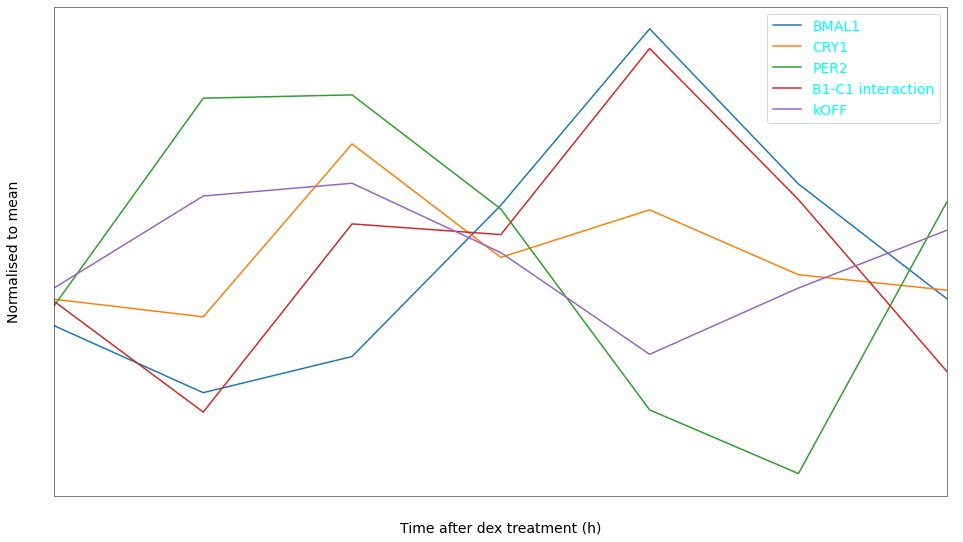

In [18]:
N_A = 6.022E23
V = 926.1E-15 # ±437.9 µm3 (n=116) Volume in fL as measured using Hoeschst staining of ALF cells
fac = 1E-9 * N_A * V

samples = 7
tps = np.linspace(24, 48, num=samples) # Timepoints where to evaluate the interpolation
exp_t = timelapse_data['Unnamed: 0']

Bmal1 = interp1d(exp_t, timelapse_data['Bmal1 Concentration'], kind='quadratic')
bmal1_to_clock_ratio = 1.903 # bmal1 for every clock
Clock = Bmal1(tps) / bmal1_to_clock_ratio
Cry1 = interp1d(exp_t, 2.083*timelapse_data['Cry1 Concentration'], kind='quadratic') 
Per2 = interp1d(t, p2_data, kind='quadratic') 

kd_CB_C1s = interp1d(exp_t, timelapse_data['Interaction'], kind='quadratic') 
kd_CB_C1s_std = interp1d(exp_t, timelapse_data['Interaction.1'], kind='quadratic') 
kd_CB_C1s_N = interp1d(exp_t, timelapse_data['Interaction.2'], kind='quadratic') 
kd_SEM = np.power(1*(kd_CB_C1s_std(tps)/kd_CB_C1s_N(tps)), 2)

kOFF = interp1d(kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['Mean'], kind='quadratic') 
kOFF_std = interp1d(kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['SD'], kind='quadratic')
kOFF_N = interp1d(kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['N'], kind='quadratic')
# convert into off rate. Currently it is in residence time
kOFF = 1/kOFF(tps)
kOFF_std = 1/kOFF_std(tps)
kOFF_95_CI_on_mean = 1.96*(kOFF_std/kOFF_N(tps))
kOFF_SEM = 1*(kOFF_std/kOFF_N(tps))

plt.plot(tps, Bmal1(tps)/np.mean(Bmal1(tps)), label='BMAL1')
plt.plot(tps, Cry1(tps)/np.mean(Cry1(tps)), label='CRY1')
plt.plot(tps, Per2(tps)/np.mean(Per2(tps)), label='PER2')
plt.plot(tps, kd_CB_C1s(tps)/np.mean(kd_CB_C1s(tps)), label='B1-C1 interaction')
plt.plot(tps, kOFF/np.mean(kOFF), label='kOFF')
#plt.plot(tps, Clock/np.mean(Clock), label='Clock')

plt.xlim([24, 48])
plt.xlabel('Time after dex treatment (h)')
plt.ylabel('Normalised to mean')
plt.xticks([24, 28, 32, 36, 40, 44, 48])
plt.legend()

In [51]:
fitted_params = [0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821, 0.7362028 ]

kd_CB = measured_param_single_values['BMAL1:CLOCK']['kd (nM)']['LV2-WT']['Mean'] # nM Disassociation constant between Clock and Bmal1
kd_CB_C1 = measured_param_single_values['BMAL1:CRY1']['kd (nM)']['Pooled']['Mean']  # nM Disassociation constant between Bmal1 and Cry1
kd_C1_P2 = measured_param_single_values['PER2:CRY1']['kd (nM)']['LV2']['Mean'] # nM Disassociation constant between Per2 and Cry1
CB_EBOX_Kd = 10 # nM as measured by Carrie Partch
print(kd_CB)

initial_concentrations = np.array([np.array([0.0]*14)]*samples)

S = 3436 # Specific Binding sites
S_conc = S * 1E9 / (N_A * V)
print('S = {:} nM'.format(S_conc))

initial_concentrations[:, var['S']] = S_conc
initial_concentrations[:, var['B']] = Bmal1(tps)
initial_concentrations[:, var['C']] = Clock
initial_concentrations[:, var['C1']] = Cry1(tps)
initial_concentrations[:, var['P2']] = Per2(tps)
initial_concentrations = initial_concentrations.astype('float64')

ode_model = DNA_binding_model_B1(samples, initial_concentrations, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s(tps), cores=20)

result = ode_model.full_simulate(fitted_params)
kOFF_sim = result[:, 0]
equilibrium_conc_sim = np.array([el[1:] for el in result])
kOFF_sim

147.6446725113458
S = 6.161046970595631 nM
4

array([0.37399207, 0.42206214, 0.41964897, 0.38167668, 0.34110597,
       0.33924461, 0.3980978 ])

In [20]:
TP = 4 # T = 40

names =[
    'CB',
    'S',
    'CBS',
    'C1',
    'CBC1',
    'CBC1S',
    'P2',
    'C1P2',
    'CBC1P2S',
    'CBC1P2',
    'C',
    'B',
    'BC1',
    'BC1P2'
]

for i in range(14):
    print('{:}: {:}'.format(names[i], int(fac*equilibrium_conc_sim[TP, i])))

print('Total equilibirum number of sites:')
print(fac*equilibrium_conc_sim[TP, var['S']] + fac*equilibrium_conc_sim[TP, var['CBS']] + fac*equilibrium_conc_sim[TP, var['CBC1S']] + fac*equilibrium_conc_sim[TP, var['CBC1P2S']])

CB: 1327
S: 2827
CBS: 530
C1: 5107
CBC1: 186
CBC1S: 74
P2: 2369
C1P2: 264
CBC1P2S: 3
CBC1P2: 9
C: 7631
B: 14329
BC1: 2015
BC1P2: 104
Total equilibirum number of sites:
3435.9999999945053


In [21]:
# k_on = 1.78123e-02 +/- 5.93584e-02 (333.2 %)
# d_on = 2.29168e-01 +/- 4.05891e-02 (17.7 %)
# a_on = 9.88126e-01 +/- 4.02843e-02 (4.1 %)
# R_on = 4.77614e-03 +/- 3.34403e-02 (700.2 %)
# R_off = 1.98410e+01 +/- 4.37389e-02 (0.2 %)
# b_on = 9.57643e-02 +/- 1.75794e-02 (18.4 %)

TP = 4 #  T40
fac = 1E-9 * N_A * V

k_on = 1.78123e-02 
k_off = 1/2.7

'''
nM -> particles: 1E-9 * N_A * V 
/nM  -> /particle: 1/(1E-9 * N_A * V)
'''

params = [
    {'name': 'k_on', 'value': k_on / fac},     # nM^-1 s^-1
    {'name': 'k_off', 'value': kOFF[TP]},         # s^-1
]

species = [
    {'name': 'S', 'value': fac*equilibrium_conc_sim[TP, var['S']]-1},
    {'name': 'CBS', 'value': fac*equilibrium_conc_sim[TP, var['CBS']]},
    {'name': 'CB', 'value': fac*equilibrium_conc_sim[TP, var['CB']]},
    {'name': 'CBC1', 'value': fac*equilibrium_conc_sim[TP, var['CBC1']]},
    {'name': 'CBC1', 'value': fac*equilibrium_conc_sim[TP, var['CBC1S']]},
    {'name': 'marked_gene', 'value': 1},
]

print('Species')
print(species)

trajectories = 1
sim_time = 1000 #30 * 60 #* 60 #1 * 60 * 60
time_per_time = (21.82 / 1) / 1000 # (22 / 1) / 1
print('Estimated simulation time = {:0.2f} mins'.format(time_per_time * sim_time *trajectories/60))

t_0 = time.time()
smod = run_stochpy("D.1c simple model tracked binding and first arrivals",
                   trajectories, 
                   sim_time, 
                   params=params, 
                   species=species,  
                   marked_genes=None, 
                   mode='time',
                   method='Direct',
                   IsTrackPropensities=False)
t_end = time.time()
time_taken = t_end - t_0
print('Time taken = {:0.2f} s'.format(time_taken))

Species
[{'name': 'S', 'value': 2826.6812386434303}, {'name': 'CBS', 'value': 530.365004260203}, {'name': 'CB', 'value': 1327.946787952381}, {'name': 'CBC1', 'value': 186.95666067527307}, {'name': 'CBC1', 'value': 74.1698493788913}, {'name': 'marked_gene', 'value': 1}]
Estimated simulation time = 0.36 mins
Simulating...
Time taken = 10.88 s


In [22]:
params

[{'name': 'k_on', 'value': 3.19390037701806e-05},
 {'name': 'k_off', 'value': 0.3291639236339697}]

In [23]:
species

[{'name': 'S', 'value': 2826.6812386434303},
 {'name': 'CBS', 'value': 530.365004260203},
 {'name': 'CB', 'value': 1327.946787952381},
 {'name': 'CBC1', 'value': 186.95666067527307},
 {'name': 'CBC1', 'value': 74.1698493788913},
 {'name': 'marked_gene', 'value': 1}]

In [24]:
raw_data, averaged_data, distributions_data = generate_stochastic_plots(smod, multiple_trajectories=int(trajectories > 1))
#raw_data_grid

In [25]:
m = {}
i = 0
for el in raw_data['data']:
    m[el['name']] = i
    i+=1
m['CBS']

2

In [26]:
raw_data['data'][m['CB']]['y'][-1] + raw_data['data'][m['CBS']]['y'][-1]

1857.0

In [27]:
raw_data['data'][m['CB']]['y'][-1]

1441.0

In [26]:
def single_component_normalised(t, k_OFF):
    return 1 - np.exp(-k_OFF * t)

def single_component(t, k_OFF, A, c0):
    return A * (1 - np.exp(-k_OFF * t)) + c0

In [27]:
def fit_rate(t, Y, skip_values=1):
    fit_params, cov_mat = curve_fit(single_component, t, Y)
    fit = single_component(t, *fit_params)
    return fit, fit_params

In [28]:
def fit_rate_norm(t, Y, skip_values=1):
    fit_params, cov_mat = curve_fit(single_component_normalised, t, Y)
    fit = single_component_normalised(t, *fit_params)
    return fit, fit_params

In [31]:
raw_data['data'][m['CB']]

{'type': 'scatter',
 'x': array([0.00000000e+00, 1.28955312e-04, 2.58546016e-03, ...,
        9.99995779e+02, 9.99998467e+02, 1.00000000e+03]),
 'y': array([1327., 1328., 1329., ..., 1440., 1441., 1441.]),
 'name': 'CB',
 'line': {'color': 'blue'}}

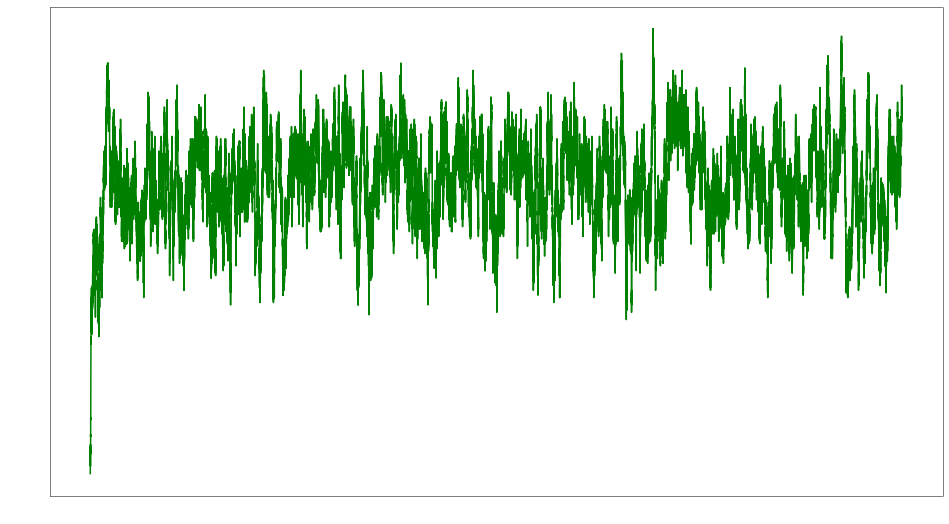

In [29]:
plt.plot(raw_data['data'][m['CB']]['x'], raw_data['data'][m['CB']]['y'], color='green')

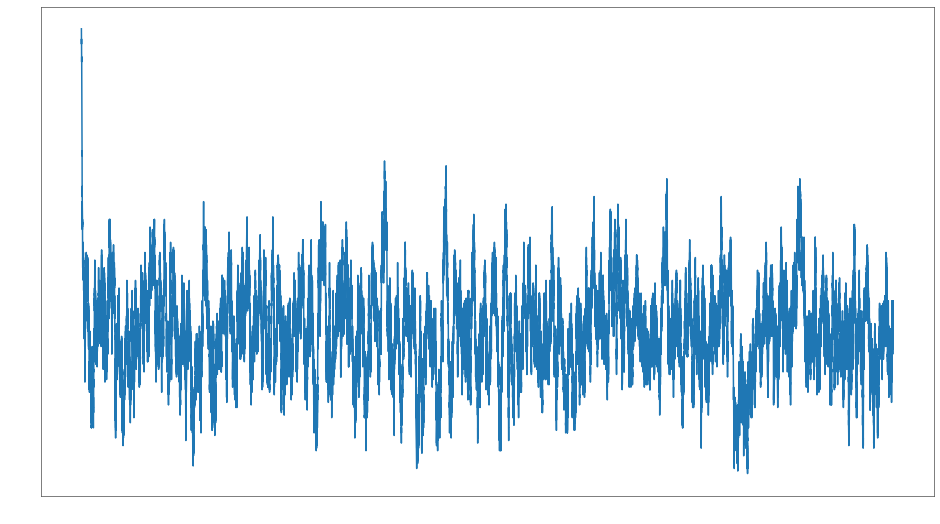

In [33]:
v = 'CBS'
plt.plot(raw_data['data'][m[v]]['x'], raw_data['data'][m[v]]['y'])

[  82.12729191 2764.20890606  609.00000197]


/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


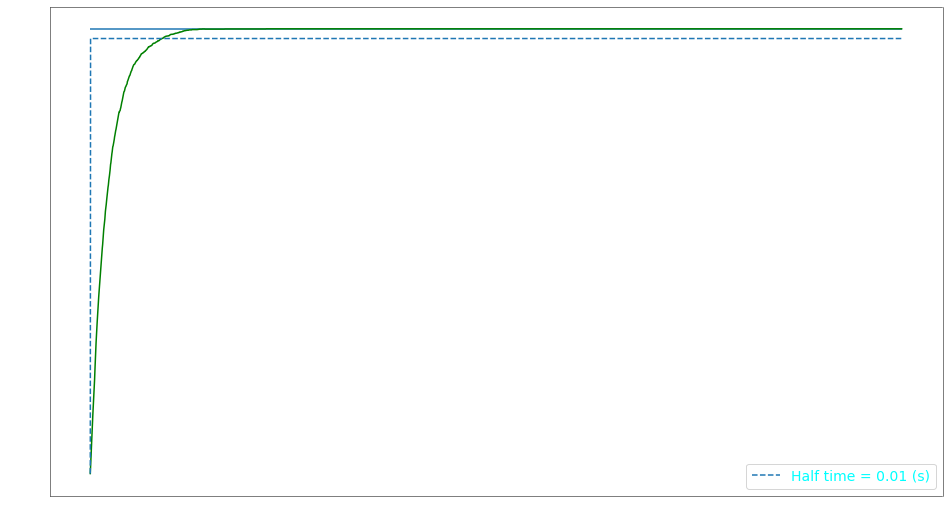

In [34]:
plt.plot(raw_data['data'][m['S']]['x'][::100], 3435-raw_data['data'][m['S']]['y'][::100], color='green')
fit, fit_params = fit_rate(raw_data['data'][m['S']]['x'][::100], 3435-raw_data['data'][m['S']]['y'][::100])
print(fit_params)
plt.plot(raw_data['data'][m['S']]['x'][::100].flatten(), fit, '--', label='Half time = {:0.2f} (s)'.format(np.log(2)/(fit_params[0])))
plt.hlines(3435, 0, sim_time)
plt.legend()

[0.05798154]


<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)


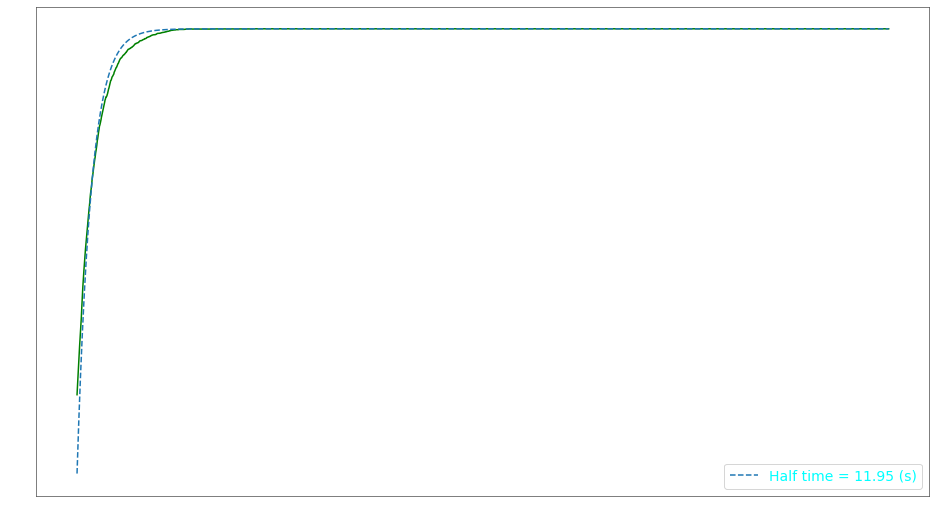

In [35]:
plt.plot(raw_data['data'][m['S']]['x'][::100], (3435-raw_data['data'][m['S']]['y'][::100])/(3435), color='green')
fit, fit_params = fit_rate_norm(raw_data['data'][m['S']]['x'][::100], (3435-raw_data['data'][m['S']]['y'][::100])/(3435))
print(fit_params)
plt.plot(raw_data['data'][m['S']]['x'][::100].flatten(), fit, '--', label='Half time = {:0.2f} (s)'.format(np.log(2)/(fit_params[0])))
plt.legend()

[0.05178809]


<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)


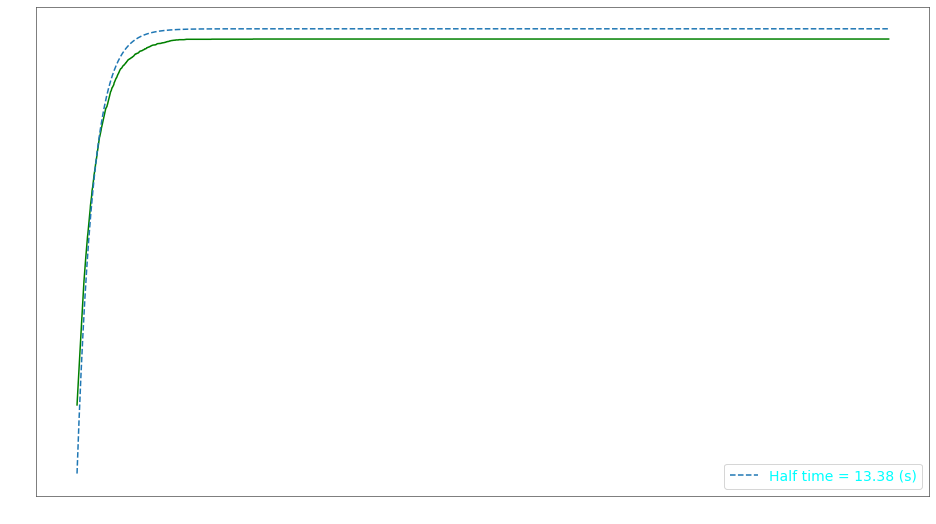

In [36]:
all_S0 = raw_data['data'][m['S0']]['y'][::100] + raw_data['data'][m['CBS']]['y'][::100] + raw_data['data'][m['CBC1S0']]['y'][::100]
plt.plot(raw_data['data'][m['S0']]['x'][::100], all_S0/(3435), color='green')
fit, fit_params = fit_rate_norm(raw_data['data'][m['S0']]['x'][::100], all_S0/(3435))
print(fit_params)
plt.plot(raw_data['data'][m['S0']]['x'][::100].flatten(), fit, '--', label='Half time = {:0.2f} (s)'.format(np.log(2)/(fit_params[0])))
plt.legend()

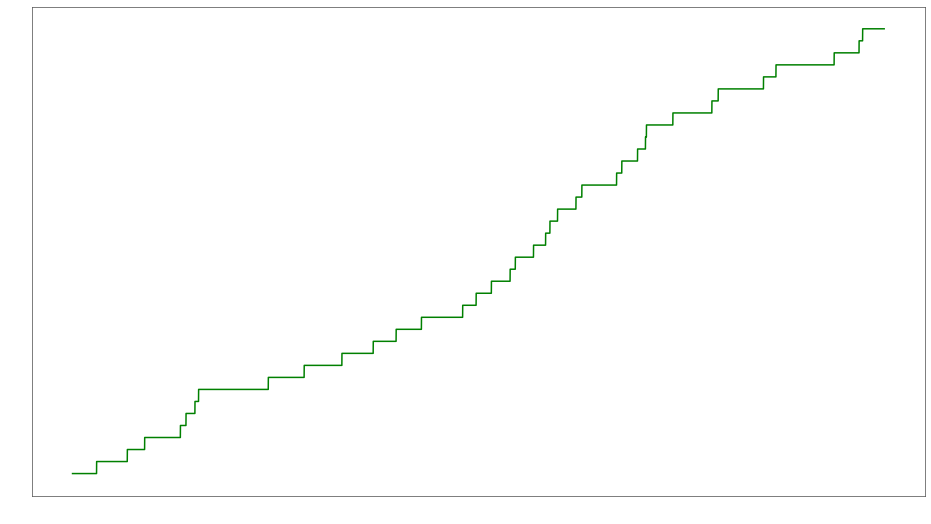

In [37]:
plt.plot(raw_data['data'][m['CB_bind']]['x'], raw_data['data'][m['CB_bind']]['y'], color='green')

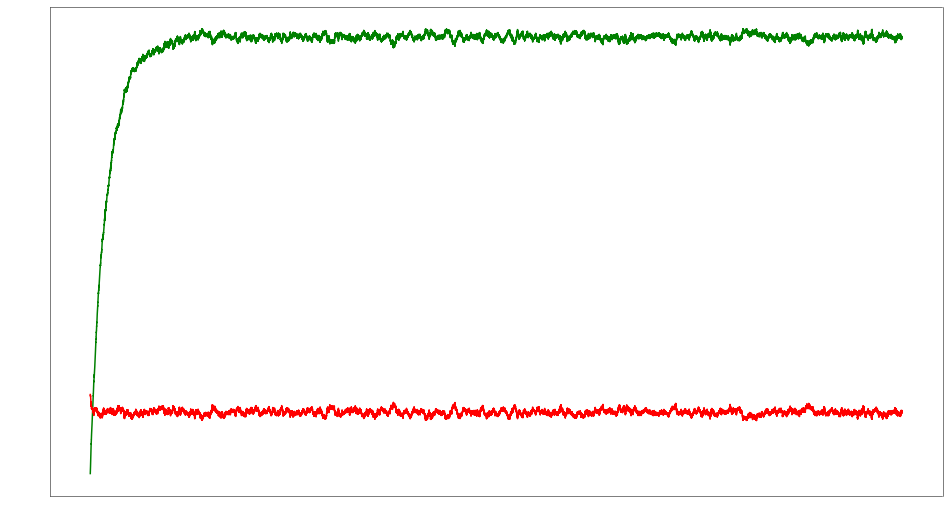

In [39]:
plt.plot(raw_data['data'][m['S0']]['x'], raw_data['data'][m['S0']]['y'], color='green')
plt.plot(raw_data['data'][m['CBS']]['x'], raw_data['data'][m['CBS']]['y'], color='red')

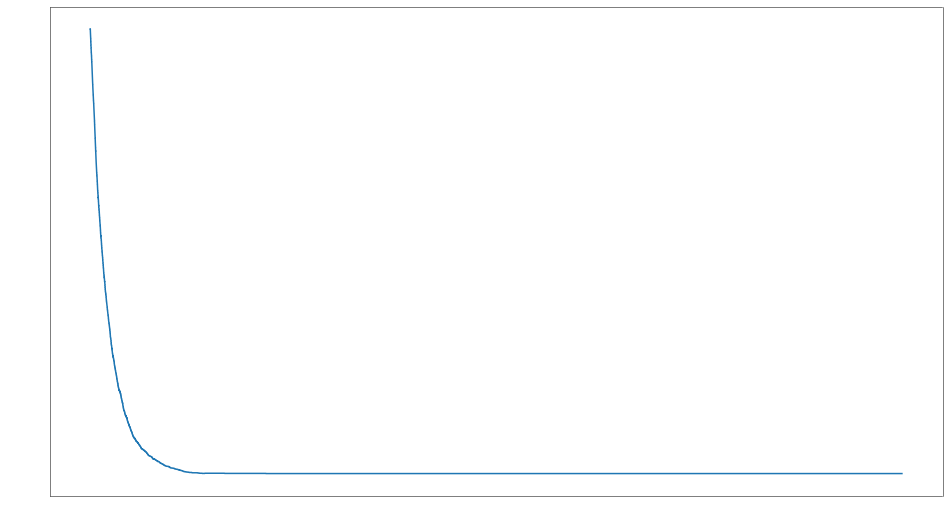

In [40]:
plt.plot(raw_data['data'][m['S']]['x'], raw_data['data'][m['S']]['y'])

In [31]:
def hetero_dimerisation_limit(kd, x_0, y_0):
    ''' Yeilds the concentration of the dimer in the limit as t goes to infinity '''
    return (x_0 + y_0 + kd - np.sqrt((x_0 + y_0 + kd)**2 - 4 * x_0 * y_0)) / 2

In [119]:
smod_grid = [None] * samples
trajectories = 1

sim_time = 10 * 60 # 1 * 60

raw_data_grid = [None] * samples
averaged_data_grid = [None] * samples
distributions_data_grid = [None] * samples

#time_per_time = (21.82 / 1) / 1000 # (22 / 1) / 1
print('Estimated simulation time = {:0.2f} mins'.format(time_per_time * samples * sim_time *trajectories/60))

def run_timecourse_sim():
    for n in tqdm(range(samples)):
        params = [
            {'name': 'k_on', 'value': fitted_params[0] / fac},     # nM^-1 s^-1
            {'name': 'k_off', 'value': kOFF_sim[n]},         # s^-1
        ]

        species = [
            {'name': 'S', 'value': fac*equilibrium_conc_sim[n, var['S']]-1},
            {'name': 'CBS', 'value': fac*equilibrium_conc_sim[n, var['CBS']]},
            {'name': 'CB', 'value': fac*equilibrium_conc_sim[n, var['CB']]},
            {'name': 'CBC1', 'value': fac*equilibrium_conc_sim[n, var['CBC1']]},
            {'name': 'CBC1S', 'value': fac*equilibrium_conc_sim[n, var['CBC1S']]},
            {'name': 'marked_gene', 'value': 1},
        ]
        smod_grid[n] = run_stochpy("D.1c simple model tracked binding and first arrivals", 
                                   trajectories, 
                                   sim_time, 
                                   params=params, 
                                   species=species,  
                                   mode='time',
                                   method='Direct',
                                   marked_genes=None)
        # Calculate the average results straight afterwards as only the last stochastic sim is saved in the temp folder
        raw_data_grid[n], averaged_data_grid[n], distributions_data_grid[n] = generate_stochastic_plots(smod_grid[n], multiple_trajectories=int(trajectories > 1))
    return

run_timecourse_sim()

  0%|          | 0/7 [00:00<?, ?it/s]

Estimated simulation time = 1.53 mins
Simulating...


 14%|█▍        | 1/7 [00:04<00:26,  4.45s/it]

Simulating...


 29%|██▊       | 2/7 [00:08<00:20,  4.03s/it]

Simulating...


 43%|████▎     | 3/7 [00:12<00:16,  4.09s/it]

Simulating...


 57%|█████▋    | 4/7 [00:18<00:14,  4.82s/it]

Simulating...


 71%|███████▏  | 5/7 [00:26<00:11,  5.95s/it]

Simulating...


 86%|████████▌ | 6/7 [00:34<00:06,  6.61s/it]

Simulating...


100%|██████████| 7/7 [00:38<00:00,  5.57s/it]


100%|██████████| 7/7 [00:00<00:00, 71.54it/s]


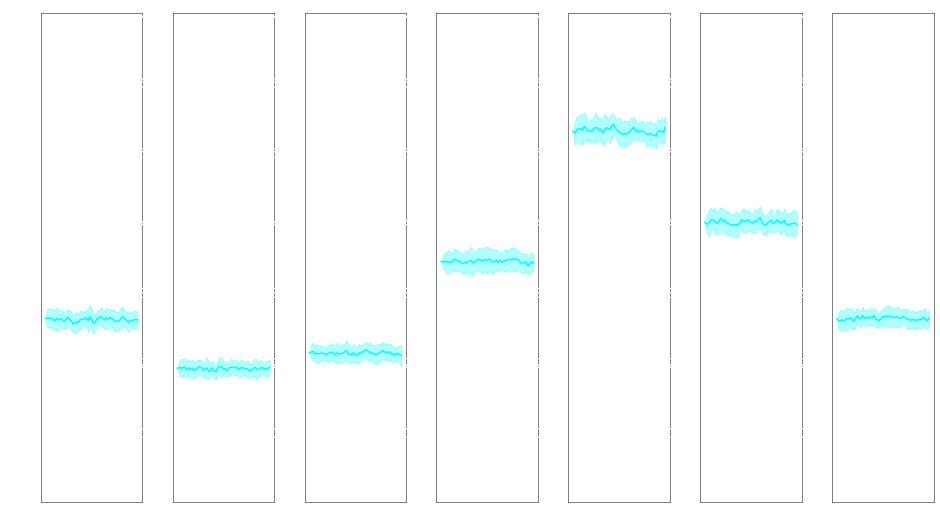

In [115]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 700
axs =  [None] * samples
for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3]['y'], averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='cyan', alpha=0.3)
    #axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='orange')
    #axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3]['y'], averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

In [ ]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')
samples = 7

initial_concentrations = np.array([np.array([0.0]*14)]*samples)

k_on = 1.78123e-02
k_off_star = k_on * 10
d_on = 2.29168e-01
d_off = kd_CB_C1s(tps) * d_on
a_on = 9.88126e-01
a_off = 82 * a_on
R_on = 4.77614e-03
R_off = 1.98410e+01
b_on = 9.57643e-02
b_off = measured_param_single_values['BMAL1:CLOCK']['kd (nM)']['LV2-WT']['Mean'] * b_on

initial_concentrations[:, var['S']] = 3435 / fac #_conc
initial_concentrations[:, var['B']] = Bmal1(tps)
initial_concentrations[:, var['C']] = Clock
initial_concentrations[:, var['C1']] = Cry1(tps)
initial_concentrations[:, var['P2']] = Per2(tps)
initial_concentrations = initial_concentrations.astype('float64')
print(initial_concentrations[0])

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 500#20 #110
axs =  [None] * samples
for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], (1/scale_factor)*averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], (1/scale_factor)*averaged_data_grid[n]['data'][m['CBS']*3]['y'], (1/scale_factor)*averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='cyan', alpha=0.3)
    times = np.linspace(0, sim_time, num=200000)
    #Y = odeint(derivatives, np.array(initial_concentrations[n, :]), times, args=(k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    #print((1/scale_factor)*fac*Y[-1, var['CBS']])
    #axs[n].plot(times, (1/scale_factor)*fac*Y[:, var['CBS']], color='red')
    #axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='orange')
    #axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3]['y'], averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])

plt.subplots_adjust(wspace=.3, hspace=.5)

100%|██████████| 7/7 [00:00<00:00, 65.89it/s]


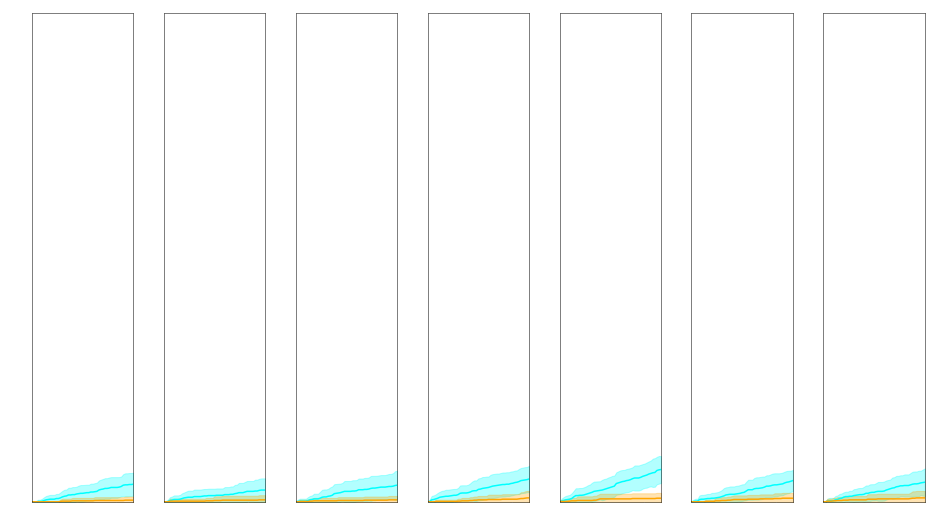

In [116]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 50 #25
axs =  [None] * samples
for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CB_bind']*3]['y'], averaged_data_grid[n]['data'][m['CB_bind']*3+2]['y'], color='cyan', alpha=0.3)
    axs[n].plot(averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CBC1_bind']*3]['y'], averaged_data_grid[n]['data'][m['CBC1_bind']*3+2]['y'], color='orange', alpha=0.3)
    axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])

plt.subplots_adjust(wspace=.3, hspace=.5)

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
 29%|██▊       | 2/7 [00:00<00:00, 12.00it/s]<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
 86%|████████▌ | 6/7 [00:00<00:00,  7.63it/s]<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
100%|██████████| 7/7 [00:00<00:00,  8.43it/s]


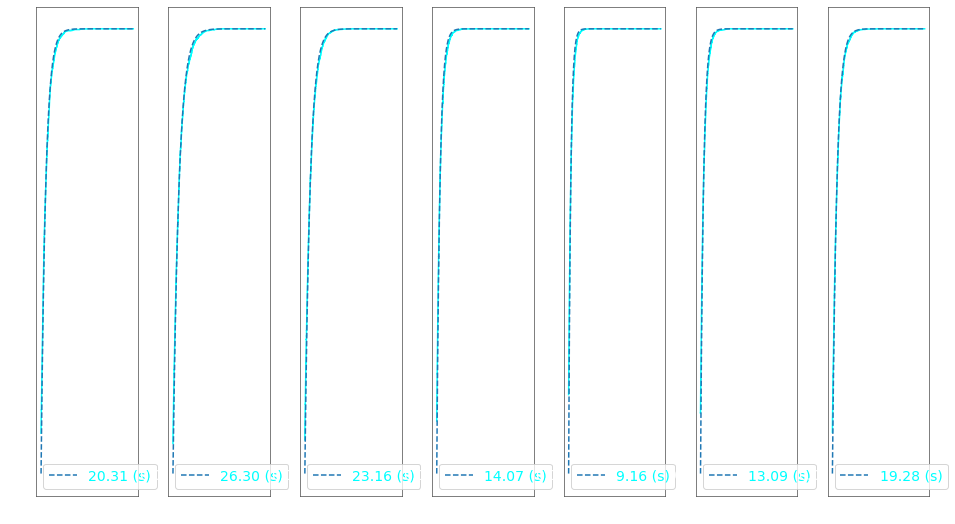

In [122]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 25
axs =  [None] * samples

WT_arrival_rates = []
WT_arrival_fits = []

for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(raw_data_grid[n]['data'][m['S']]['x'][::1], (S - raw_data_grid[n]['data'][m['S']]['y'][::1])/S, color='cyan')
    
    fit, fit_params = fit_rate_norm(raw_data_grid[n]['data'][m['S']]['x'][::1], (S - raw_data_grid[n]['data'][m['S']]['y'][::1])/S)
    WT_arrival_rates.append(fit_params[0])#
    WT_arrival_fits.append(fit)
    #print(fit_params)
    axs[n].plot(raw_data_grid[n]['data'][m['S']]['x'][::1].flatten(), fit, '--', label='{:0.2f} (s)'.format(np.log(2)/(fit_params[0])))
    axs[n].legend()
    #axs[n].set_xlim([0, 5*60])
    #axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

In [ ]:
WT_arrival_rates

In [ ]:
raw_data_grid[n]['data'][m['S']]['y'][::100]

In [74]:
WT_arrival_fits[0][:end_index:10]

array([0.        , 0.13704608, 0.25430001, 0.35485173, 0.44418824,
       0.52047649, 0.58521615, 0.6417736 , 0.69149484, 0.73459516,
       0.76992434, 0.80199438, 0.83028958, 0.85398754, 0.87334114,
       0.89037362, 0.9055995 , 0.91823082, 0.92941373, 0.93902966,
       0.94779312, 0.95489273, 0.96126714, 0.96657115, 0.97114013,
       0.97486606, 0.97805582, 0.98103721, 0.98370925, 0.98597603,
       0.98791671, 0.98960688, 0.99107359, 0.99229925, 0.99332015,
       0.99425886, 0.99507833, 0.99578494, 0.99638858, 0.99688086,
       0.99731961, 0.99768386, 0.99800669, 0.99827788, 0.99851821,
       0.99872018, 0.99889666, 0.99904648, 0.9991761 , 0.9992882 ,
       0.99938508, 0.99946856, 0.99954559, 0.99960738, 0.999662  ,
       0.99970992, 0.99975085, 0.99978511, 0.99981523, 0.99984026,
       0.99986235, 0.99988062, 0.99989654, 0.99991086, 0.99992306,
       0.99993327, 0.9999427 , 0.99995058, 0.99995711, 0.99996311,
       0.99996804, 0.99997237, 0.99997624, 0.99997954, 0.99998

In [97]:
raw_data_grid[n]['data'][m['S']]['x'][::skip]

array([  0.        ,  39.83954589,  79.96614953, 120.55040656,
       160.83730728, 201.31433832, 241.07745463, 281.53979006,
       321.93555982, 362.24427377, 402.99299592, 443.58517444,
       483.51957979, 523.41522876, 563.36846548])

In [125]:
end_index = -1 #10000
skip = 100

save_out_array = []
header_string = ''
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']


save_out_array.append(raw_data_grid[1]['data'][m['S']]['x'][:end_index:skip])
save_out_array.append(((S - raw_data_grid[1]['data'][m['S']]['y'][:end_index:skip])/S))
save_out_array.append(WT_arrival_fits[1][:end_index:skip])
header_string += time_labels[1] + ' Time (s)'
header_string += ', ' + time_labels[1] + ' {:}'.format(WT_arrival_rates[1]) 
header_string += ', ' + time_labels[1] + ' fit'

print(header_string)
#print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '29-7-21 all gene arrivals WT T28.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

T28 Time (s), T28 0.026354710049776672, T28 fit


In [109]:
end_index = 10000
skip = 100

save_out_array = []
header_string = ''
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(raw_data_grid[n]['data'][m['S']]['x'][:end_index:skip])
    save_out_array.append(((S - raw_data_grid[n]['data'][m['S']]['y'][:end_index:skip])/S))
    save_out_array.append(WT_arrival_fits[n][:end_index:skip])
    header_string += ', ' + time_labels[n] + ' Time (s)'
    header_string += ', ' + time_labels[n] + ' {:}'.format(WT_arrival_rates[n]) 
    header_string += ', ' + time_labels[n] + ' fit'

header_string = header_string[2:] #  remove comma at start
print(header_string)
#print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '29-7-21 all gene arrivals WT.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 7/7 [00:00<00:00, 24797.41it/s]

T24 Time (s), T24 0.03391838114153413, T24 fit, T28 Time (s), T28 0.027014606646860454, T28 fit, T32 Time (s), T32 0.029724898511175234, T32 fit, T36 Time (s), T36 0.049254098601528185, T36 fit, T40 Time (s), T40 0.07744301877864508, T40 fit, T44 Time (s), T44 0.04922431522335881, T44 fit, T48 Time (s), T48 0.037087698324513134, T48 fit



<ipython-input-109-fae23be8a9d7>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(save_out_array).transpose(),


TypeError: Mismatch between array dtype ('object') and format specifier ('%.6f')

In [ ]:
visits_per_min = np.zeros(samples)
visits_per_min_std = np.zeros(samples)

visits_per_min_C1 = np.zeros(samples)
visits_per_min_C1_std = np.zeros(samples)

for n in range(samples):
    visits_per_min[n] = 60 * averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'][-1] / sim_time
    visits_per_min_std[n] = 60 * (averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'][-1] - averaged_data_grid[n]['data'][m['CB_bind']*3]['y'][-1]) / sim_time
    
    visits_per_min_C1[n] = 60 * averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'][-1] / sim_time
    visits_per_min_C1_std[n] = 60 * (averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'][-1] - averaged_data_grid[n]['data'][m['CBC1_bind']*3]['y'][-1]) / sim_time
    
plt.errorbar(tps, visits_per_min, yerr=visits_per_min_std/3)
plt.errorbar(tps, visits_per_min_C1, yerr=visits_per_min_C1_std/3)

In [ ]:
np.save(os.path.join(cwd, 'D.1c stochastic outputs/averaged_data_grid_full_run_20-7-21 600s.npy'), averaged_data_grid)

In [ ]:
np.save(os.path.join(cwd, 'D.1c stochastic outputs/distributions_data_grid_full_run_20-7-21  600s.npy'), distributions_data_grid)

In [ ]:
np.save(os.path.join(cwd, 'D.1c stochastic outputs/raw_data_grid_full_run_20-7-21  600s.npy'), raw_data_grid)

In [63]:
initial_concentrations_KO = np.array([np.array([0.0]*14)]*samples)

initial_concentrations_KO[:, var['S']] = S_conc
initial_concentrations_KO[:, var['B']] = Bmal1(tps)
initial_concentrations_KO[:, var['C']] = Clock
initial_concentrations_KO[:, var['C1']] = Cry1(tps)
initial_concentrations_KO[:, var['P2']] = 0 #Per2(tps)
initial_concentrations_KO = initial_concentrations_KO.astype('float64')

ode_model_KO = DNA_binding_model_B1(samples, initial_concentrations_KO, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s(tps), cores=20)

result_KO = ode_model_KO.full_simulate(fitted_params)
kOFF_sim_KO = result_KO[:, 0]
equilibrium_conc_sim_KO = np.array([el[1:] for el in result_KO])
kOFF_sim_KO

1

array([0.2684237, 0.2684237, 0.2684237, 0.2684237, 0.2684237, 0.2684237,
       0.2684237])

In [52]:
column_names =[
    'kOFF',
    'CB',
    'S',
    'CBS',
    'C1',
    'CBC1',
    'CBC1S',
    'P2',
    'C1P2',
    'CBC1P2S',
    'CBC1P2',
    'C',
    'B',
    'BC1',
    'BC1P2'
]
len(column_names)

15

In [ ]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_KO
nums[:, 1:] = nums[:, 1:] #* 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/20-7-21 fitting concs KO.xlsx")

In [ ]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_KO
nums[:, 1:] = nums[:, 1:] * 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/20-7-21 fitting nums KO.xlsx")

In [ ]:
np.mean(kOFF_sim_KO)

In [ ]:
np.mean(kOFF_sim)

In [64]:
smod_grid_KO = [None] * samples
trajectories = 30 #30
# Takes about 1M steps to sim 0.5 seconds. This takes  about 77 seconds. Hence, ~140 seconds for 1 seconds of simulation
sim_time = 10 * 60
steps = 25000000

raw_data_grid_KO = [None] * samples
averaged_data_grid_KO = [None] * samples
distributions_data_grid_KO = [None] * samples

#time_per_time = (39 / 1) / 60
print('Estimated simulation time = {:0.2f} mins'.format(time_per_time * samples * sim_time *trajectories/60))

#@discord_sender(webhook_url=webhook_url)
def run_timecourse_KO_sim():
    for n in tqdm(range(samples)):

        params = [
            {'name': 'k_on', 'value': fitted_params[0] / fac},     # nM^-1 s^-1
            {'name': 'k_off', 'value': kOFF_sim_KO[n]},         # s^-1
        ]
        
        species = [
            {'name': 'S', 'value': fac*equilibrium_conc_sim[n, var['S']]-1},
            {'name': 'CBS', 'value': fac*equilibrium_conc_sim[n, var['CBS']]},
            {'name': 'CB', 'value': fac*equilibrium_conc_sim[n, var['CB']]},
            {'name': 'CBC1', 'value': fac*equilibrium_conc_sim[n, var['CBC1']]},
            {'name': 'CBC1S', 'value': fac*equilibrium_conc_sim[n, var['CBC1S']]},
            {'name': 'marked_gene', 'value': 1},
        ]
        
        smod_grid_KO[n] = run_stochpy("D.1c simple model tracked binding and first arrivals", #"D.1b stochastic model all binding tracked small volume", 
                                   trajectories, 
                                   sim_time, 
                                   params=params, 
                                   species=species,  
                                   mode='time',
                                   method='Direct',
                                   marked_genes=None)
        # Calculate the average results straight afterwards as only the last stochastic sim is saved in the temp folder
        raw_data_grid_KO[n], averaged_data_grid_KO[n], distributions_data_grid_KO[n] = generate_stochastic_plots(smod_grid_KO[n], multiple_trajectories=int(trajectories > 1))
    return 

run_timecourse_KO_sim()

  0%|          | 0/7 [00:00<?, ?it/s]

Estimated simulation time = 45.82 mins
Simulating...


 14%|█▍        | 1/7 [02:20<14:04, 140.70s/it]

Simulating...


 29%|██▊       | 2/7 [04:15<10:28, 125.60s/it]

Simulating...


 43%|████▎     | 3/7 [06:20<08:21, 125.37s/it]

Simulating...


 57%|█████▋    | 4/7 [09:26<07:26, 148.98s/it]

Simulating...


 71%|███████▏  | 5/7 [13:22<06:01, 180.63s/it]

Simulating...


 86%|████████▌ | 6/7 [16:21<02:59, 179.87s/it]

Simulating...


100%|██████████| 7/7 [18:37<00:00, 159.68s/it]


100%|██████████| 7/7 [00:00<00:00, 64.18it/s]


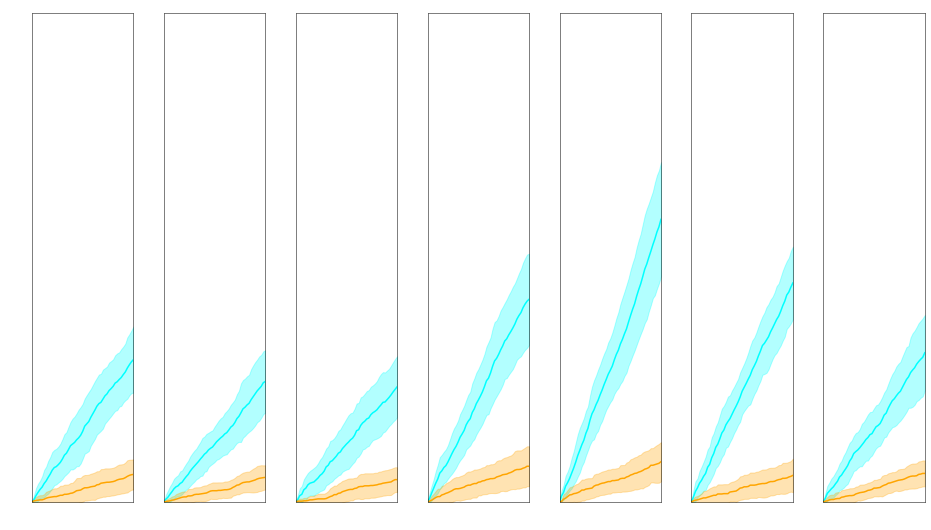

In [65]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 50
axs =  [None] * samples
for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CB_bind']*3]['y'], averaged_data_grid_KO[n]['data'][m['CB_bind']*3+2]['y'], color='cyan', alpha=0.3)
    axs[n].plot(averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3]['y'], averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+2]['y'], color='orange', alpha=0.3)
    axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

100%|██████████| 7/7 [00:00<00:00, 66.74it/s]


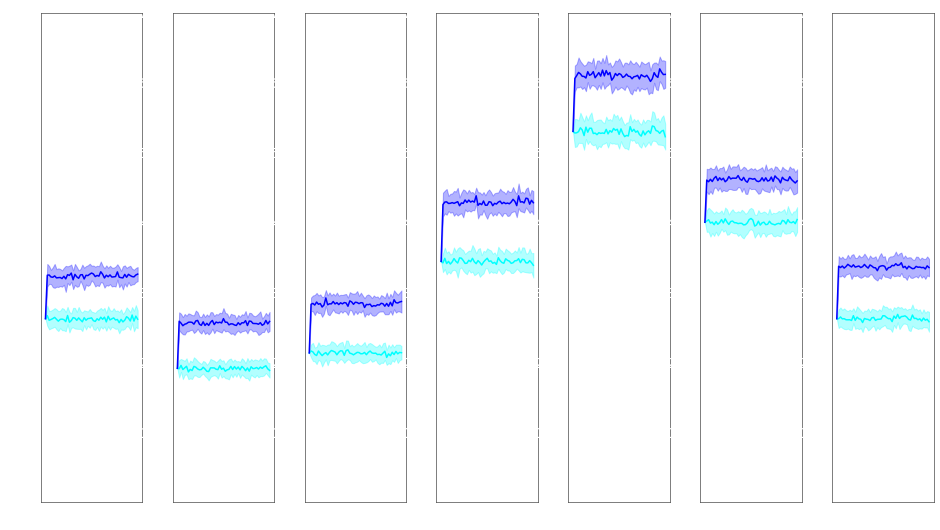

In [66]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 700#20 #110
axs =  [None] * samples
for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3]['y'], averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='cyan', alpha=0.3)
    
    axs[n].plot(averaged_data_grid_KO[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBS']*3+1]['y'], color='blue')
    axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBS']*3]['y'], averaged_data_grid_KO[n]['data'][m['CBS']*3+2]['y'], color='blue', alpha=0.3)
    times = np.linspace(0, sim_time, num=200000)
    #Y = odeint(derivatives, initial_concentrations[n], times, args=(k_on, k_off, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    #print((1/scale_factor)*fac*Y[-1, var['CBS']])
    #axs[n].plot(times, (1/scale_factor)*fac*Y[:, var['CBS']], color='red')
    #axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='orange')
    #axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3]['y'], averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

In [67]:
end_index = -1 #100000

save_out_array = []
save_out_array.append(averaged_data_grid_KO[0]['data'][3*m['CB_bind']+1]['x'][:end_index])
header_string = 'time (s)'
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(averaged_data_grid[n]['data'][3*m['CBS']+1]['y'][:end_index].tolist())
    save_out_array.append(averaged_data_grid[n]['data'][3*m['CBS']]['y'][:end_index].tolist())
    save_out_array.append(averaged_data_grid[n]['data'][3*m['CBS']+2]['y'][:end_index].tolist())
    
    save_out_array.append(averaged_data_grid_KO[n]['data'][3*m['CBS']+1]['y'][:end_index].tolist())
    save_out_array.append(averaged_data_grid_KO[n]['data'][3*m['CBS']]['y'][:end_index].tolist())
    save_out_array.append(averaged_data_grid_KO[n]['data'][3*m['CBS']+2]['y'][:end_index].tolist())
    
    header_string += ', ' + time_labels[n] + ' WT CBS mean' 
    header_string += ', ' + time_labels[n] + ' WT CBS lower bound (-std) (N={:})'.format(trajectories) 
    header_string += ', ' + time_labels[n] + ' WT CBS upper bound (+std) (N={:})'.format(trajectories) 
    
    header_string += ', ' + time_labels[n] + ' KO CBS mean' 
    header_string += ', ' + time_labels[n] + ' KO CBS lower bound (-std) (N={:})'.format(trajectories) 
    header_string += ', ' + time_labels[n] + ' KO CBS upper bound (+std) (N={:})'.format(trajectories) 
    
        
print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '29-7-21 Correct volume CBS WT and KO.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 7/7 [00:00<00:00, 23045.63it/s]

[[  0.         262.         262.         ... 262.         262.
  262.        ]
 [ 12.         266.3        251.69600511 ... 337.03333333 322.57077631
  351.49589035]
 [ 24.         259.73333333 246.72325177 ... 335.16666667 322.33939537
  347.99393796]
 ...
 [564.         267.23333333 255.73062834 ... 335.36666667 323.01762262
  347.71571071]
 [576.         258.56666667 243.89087405 ... 333.13333333 318.87913317
  347.38753349]
 [588.         265.63333333 249.81671057 ... 337.6        324.11272204
  351.08727796]]


In [ ]:
end_index = 200000

save_out_array = []
save_out_array.append(raw_data_grid[n]['data'][m['S']]['x'][:end_index:10])
header_string = 'time (s)'
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(raw_data_grid[n]['data'][m['S']]['y'][:end_index:10])
    header_string += ', ' + time_labels[n] + ' {:}'.format(WT_arrival_rates[n]) 
        
print(np.array(save_out_array)[0].shape)
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '29-7-21 all gene arrivals WT.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
<ipython-input-28-a2df25029915>:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-k_OFF * t)
100%|██████████| 7/7 [00:00<00:00, 65.27it/s]


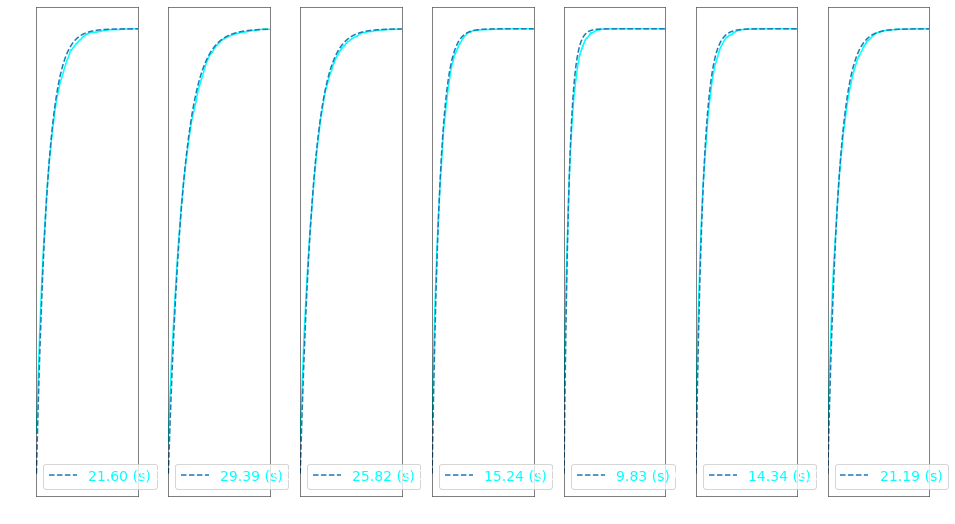

In [68]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 25
axs =  [None] * samples

KO_arrival_rates = []

for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(raw_data_grid_KO[n]['data'][m['S']]['x'][::100], (S - raw_data_grid_KO[n]['data'][m['S']]['y'][::100])/S, color='cyan')
    
    fit, fit_params = fit_rate_norm(raw_data_grid_KO[n]['data'][m['S']]['x'][::100], (S - raw_data_grid_KO[n]['data'][m['S']]['y'][::100])/S)
    KO_arrival_rates.append(fit_params[0])
    #print(fit_params)
    axs[n].plot(raw_data_grid_KO[n]['data'][m['S']]['x'][::100].flatten(), fit, '--', label='{:0.2f} (s)'.format(np.log(2)/(fit_params[0])))
    axs[n].legend()
    axs[n].set_xlim([0, 5*60])
    #axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

In [207]:
end_index = 200000

save_out_array = []
save_out_array.append(raw_data_grid_KO[n]['data'][m['S']]['x'][:end_index:10])
header_string = 'time (s)'
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(raw_data_grid_KO[n]['data'][m['S']]['y'][:end_index:10])
    header_string += ', ' + time_labels[n] + ' {:}'.format(KO_arrival_rates[n]) 
        
print(np.array(save_out_array)[0].shape)
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '20-7-21 all gene arrivals KO.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 7/7 [00:00<00:00, 10802.11it/s]

(20000,)


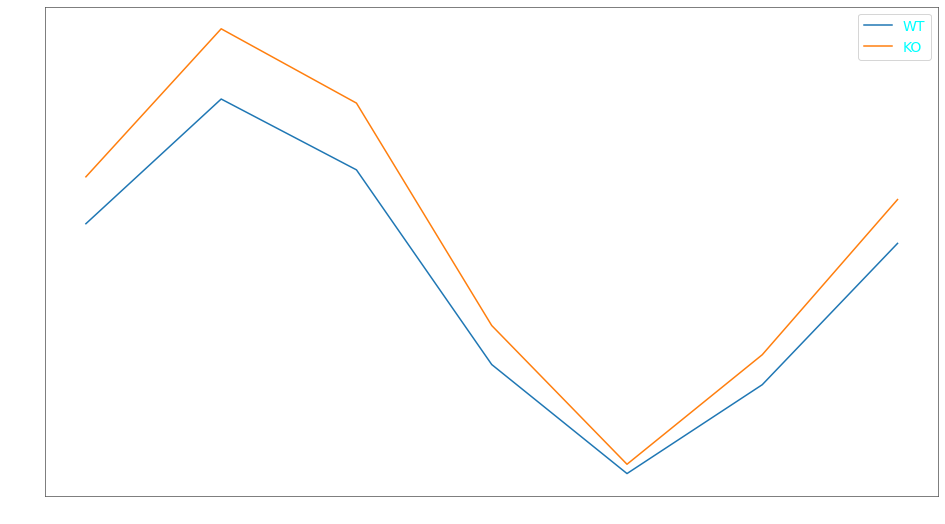

In [208]:
plt.plot([24, 28, 32, 36, 40, 44, 48], np.log(2)/np.array(WT_arrival_rates), label='WT')
plt.plot([24, 28, 32, 36, 40, 44, 48], np.log(2)/np.array(KO_arrival_rates), label='KO')
plt.legend()

In [314]:
np.save(os.path.join(cwd, 'D.1c stochastic outputs/averaged_data_grid_KO_full_run_20-7-21 600s.npy'), averaged_data_grid_KO)

In [315]:
np.save(os.path.join(cwd, 'D.1c stochastic outputs/distributions_data_grid_KO_full_run_20-7-21 600s.npy'), distributions_data_grid_KO)

In [316]:
np.save(os.path.join(cwd, 'D.1c stochastic outputs/raw_data_grid_KO_full_run_20-7-21 600s.npy'), raw_data_grid_KO)

100%|██████████| 7/7 [00:00<00:00, 57.34it/s]


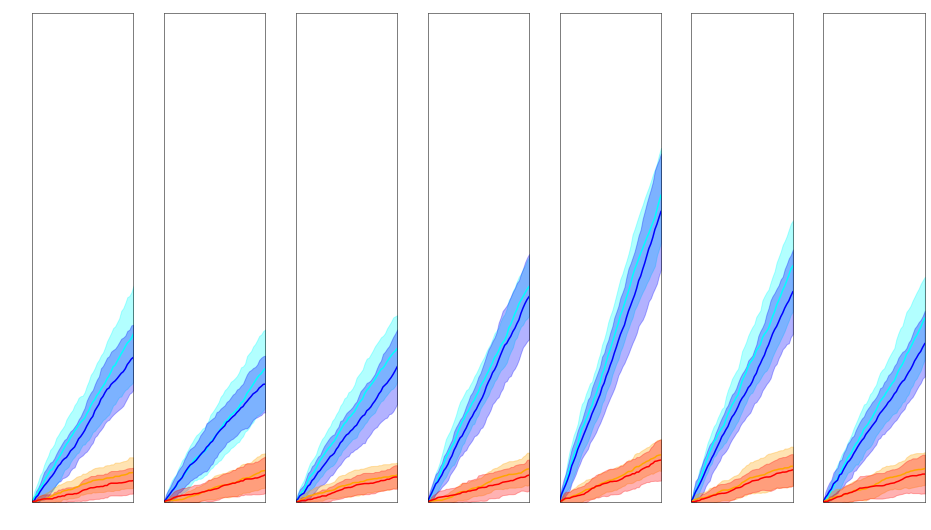

In [369]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = 10*60# #5 * 60
y_axis_lim = 50
axs =  [None] * samples
for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    
    axs[n].plot(averaged_data_grid[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CB_bind']*3]['y'], averaged_data_grid[n]['data'][m['CB_bind']*3+2]['y'], color='cyan', alpha=0.3)
    axs[n].plot(averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['y'], color='blue')
    axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CB_bind']*3]['y'], averaged_data_grid_KO[n]['data'][m['CB_bind']*3+2]['y'], color='blue', alpha=0.3)
    
    axs[n].plot(averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid[n]['data'][m['CBC1_bind']*3]['y'], averaged_data_grid[n]['data'][m['CBC1_bind']*3+2]['y'], color='orange', alpha=0.3)
    axs[n].plot(averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['y'], color='red')
    axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3]['y'], averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+2]['y'], color='red', alpha=0.3)
    
    axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

In [318]:
end_index = -1

save_out_array = []
save_out_array.append(averaged_data_grid[n]['data'][m['CB_bind']*3+1]['x'][:end_index])
header_string = 'time (s)'
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'][:end_index].tolist())
    save_out_array.append((averaged_data_grid[n]['data'][m['CB_bind']*3+2]['y'][:end_index] - averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'][:end_index]).tolist())
    save_out_array.append(averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'][:end_index].tolist())
    save_out_array.append((averaged_data_grid[n]['data'][m['CBC1_bind']*3+2]['y'][:end_index] - averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'][:end_index]).tolist())
    header_string += ', ' + time_labels[n] + ' CB' 
    header_string += ', ' + time_labels[n] + ' CB std (N={:})'.format(trajectories) 
    header_string += ', ' + time_labels[n] + ' CBC1' 
    header_string += ', ' + time_labels[n] + ' CBC1 std (N={:})'.format(trajectories) 
        
print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '20-7-21 Single gene visits per min average WT 600s.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 7/7 [00:00<00:00, 19508.39it/s]

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.20000000e+01 4.00000000e-01 6.11010093e-01 ... 3.39934634e-01
  1.33333333e-01 3.39934634e-01]
 [2.40000000e+01 6.66666667e-01 8.29993307e-01 ... 6.69991708e-01
  2.00000000e-01 4.00000000e-01]
 ...
 [5.64000000e+02 1.62333333e+01 4.67392293e+00 ... 4.36348485e+00
  3.30000000e+00 1.67630546e+00]
 [5.76000000e+02 1.64333333e+01 4.60205268e+00 ... 4.42028154e+00
  3.30000000e+00 1.67630546e+00]
 [5.88000000e+02 1.67000000e+01 4.69858135e+00 ... 4.29211163e+00
  3.33333333e+00 1.63978318e+00]]


In [319]:
end_index = -1

save_out_array = []
save_out_array.append(averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['x'][:end_index])
header_string = 'time (s)'
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['y'][:end_index].tolist())
    save_out_array.append((averaged_data_grid_KO[n]['data'][m['CB_bind']*3+2]['y'][:end_index] - averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['y'][:end_index]).tolist())
    save_out_array.append(averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['y'][:end_index].tolist())
    save_out_array.append((averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+2]['y'][:end_index] - averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['y'][:end_index]).tolist())
    header_string += ', ' + time_labels[n] + ' CB' 
    header_string += ', ' + time_labels[n] + ' CB std (N={:})'.format(trajectories) 
    header_string += ', ' + time_labels[n] + ' CBC1' 
    header_string += ', ' + time_labels[n] + ' CBC1 std (N={:})'.format(trajectories) 
        
print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '20-7-21 Single gene visits per min average KO 600s.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 7/7 [00:00<00:00, 31167.86it/s]

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.20000000e+01 6.66666667e-02 2.49443826e-01 ... 5.58768487e-01
  3.33333333e-02 1.79505494e-01]
 [2.40000000e+01 4.66666667e-01 6.18241233e-01 ... 8.22597512e-01
  3.33333333e-02 1.79505494e-01]
 ...
 [5.64000000e+02 1.40333333e+01 3.43009556e+00 ... 3.24910244e+00
  2.73333333e+00 1.84270333e+00]
 [5.76000000e+02 1.43000000e+01 3.27770245e+00 ... 3.22989508e+00
  2.76666667e+00 1.94393644e+00]
 [5.88000000e+02 1.46000000e+01 3.43122913e+00 ... 3.18747549e+00
  2.83333333e+00 1.98466342e+00]]


100%|██████████| 7/7 [00:00<00:00, 32.17it/s]


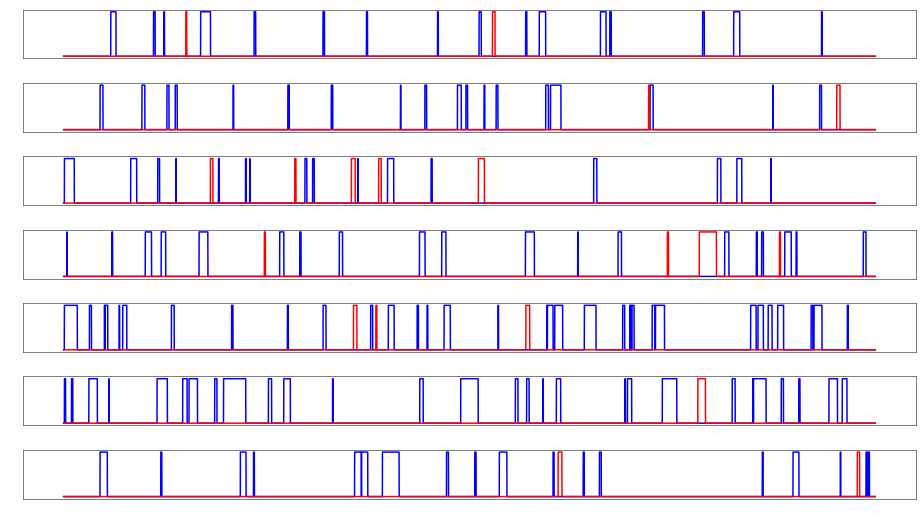

In [321]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=1, nrows=7)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #60 #5 * 60
y_axis_lim = 25
axs =  [None] * samples
for n in tqdm(range(samples)):  # [1, 2, 4]:#
    axs[n] = fig_grid.add_subplot(spec_grid[n, 0])
    
    axs[n].plot(raw_data_grid[n]['data'][m['CB_marked_gene']]['x'], raw_data_grid[n]['data'][m['CB_marked_gene']]['y'], color='blue')
    axs[n].plot(raw_data_grid[n]['data'][m['CBC1_marked_gene']]['x'], raw_data_grid[n]['data'][m['CBC1_marked_gene']]['y'], color='red')
    #axs[n].plot(raw_data_grid[n]['data'][m['CBC1P2_marked_gene']]['x'], raw_data_grid[n]['data'][m['CBC1P2_marked_gene']]['y'], color='green')
    #axs[n].plot(averaged_data_grid_KO[n]['data'][m['bind_CB']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['bind_CB']*3+1]['y'], color='blue')
    #axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['bind_CB']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['bind_CB']*3]['y'], averaged_data_grid_KO[n]['data'][m['bind_CB']*3+2]['y'], color='blue', alpha=0.3)
    
    #axs[n].plot(averaged_data_grid[n]['data'][m['bind_CBC1']*3+1]['x'], averaged_data_grid[n]['data'][m['bind_CBC1']*3+1]['y'], color='orange')
    #axs[n].fill_between(averaged_data_grid[n]['data'][m['bind_CBC1']*3+1]['x'], averaged_data_grid[n]['data'][m['bind_CBC1']*3]['y'], averaged_data_grid[n]['data'][m['bind_CBC1']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].plot(averaged_data_grid_KO[n]['data'][m['bind_CBC1']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['bind_CBC1']*3+1]['y'], color='red')
    #axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['bind_CBC1']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['bind_CBC1']*3]['y'], averaged_data_grid_KO[n]['data'][m['bind_CBC1']*3+2]['y'], color='red', alpha=0.3)
    
    #axs[n].set_xlim([0, 600])
    #axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

In [175]:
raw_data_grid[n]['data'][m['CB_marked_gene']]['x'].shape

(890705,)

In [322]:
end_index = 100000

save_out_array = []
save_out_array.append(raw_data_grid[n]['data'][m['CB_marked_gene']]['x'][:end_index].tolist())
header_string = 'time (s)'
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(raw_data_grid[n]['data'][m['CB_marked_gene']]['y'][:end_index].tolist())
    save_out_array.append(raw_data_grid[n]['data'][m['CBC1_marked_gene']]['y'][:end_index].tolist())
    header_string += ', ' + time_labels[n] + ' CB' 
    header_string += ', ' + time_labels[n] + ' CBC1' 
        
#print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '20-7-21 Single gene vists WT 600s.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 7/7 [00:00<00:00, 163.99it/s]


In [297]:
end_index = 90000

save_out_array = []
save_out_array.append(raw_data_grid_KO[n]['data'][m['CB_marked_gene']]['x'][:end_index].tolist())
header_string = 'time (s)'
time_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

for n in tqdm(range(7)):
    save_out_array.append(raw_data_grid_KO[n]['data'][m['CB_marked_gene']]['y'][:end_index].tolist())
    save_out_array.append(raw_data_grid_KO[n]['data'][m['CBC1_marked_gene']]['y'][:end_index].tolist())
    header_string += ', ' + time_labels[n] + ' CB' 
    header_string += ', ' + time_labels[n] + ' CBC1' 
        
#print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '20-7-21 Single gene vists KO 600s.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 7/7 [00:00<00:00, 182.47it/s]


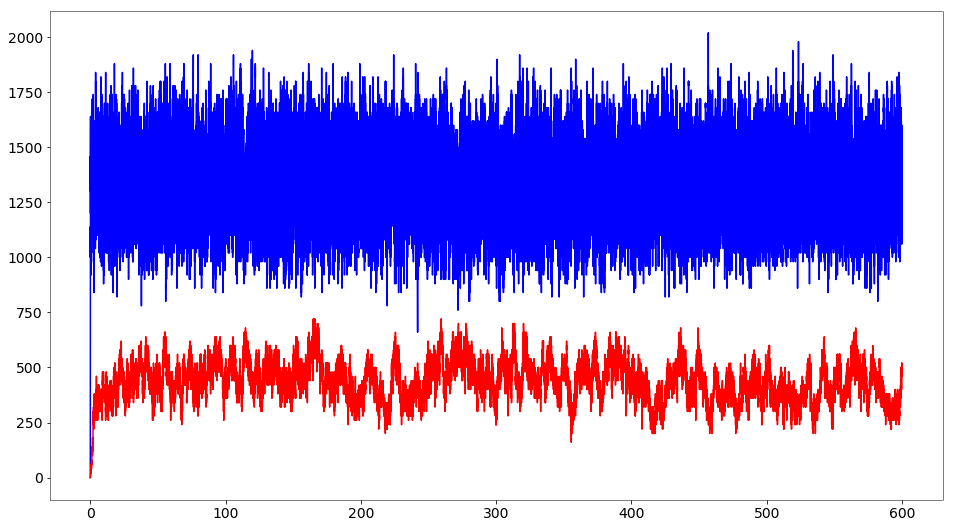

In [454]:
plt.plot(raw_data_grid[n]['data'][m['CB']]['x'], (1/scale_factor) * raw_data_grid[n]['data'][m['CB']]['y'], color='blue')
plt.plot(raw_data_grid[n]['data'][m['CBS']]['x'], (1/scale_factor) * raw_data_grid[n]['data'][m['CBS']]['y'], color='red')

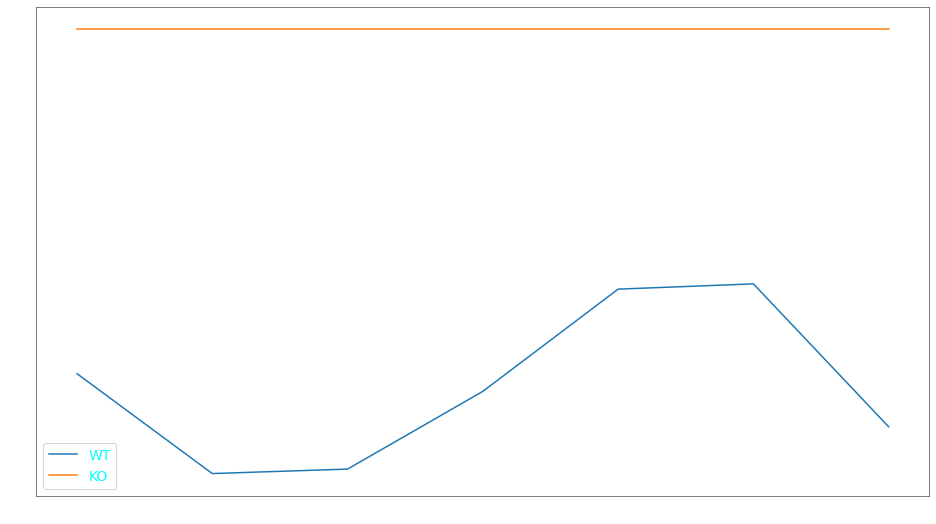

In [323]:
plt.plot([24, 28, 32, 36, 40, 44, 48], 1/kOFF_sim, label='WT')
plt.plot([24, 28, 32, 36, 40, 44, 48], 1/kOFF_sim_KO, label='KO')
#plt.hlines(np.mean(1/kOFF_sim_KO), 24, 48, label='KO')
plt.legend()

100%|██████████| 7/7 [00:00<00:00, 25266.89it/s]


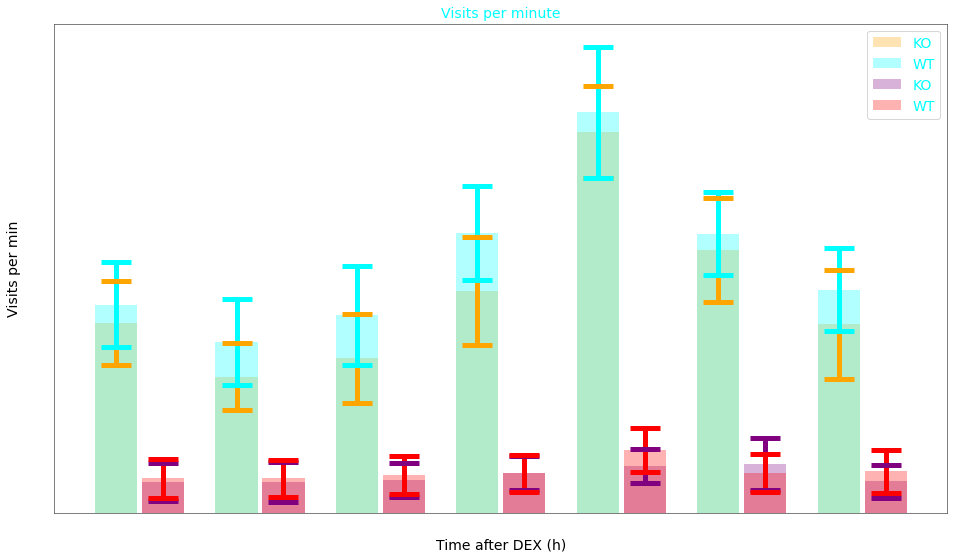

In [59]:
'''
THIS IS NOT STACKED
'''
CB_mean = []
CB_std = []
CB_KO_mean = []
CB_KO_std = []

CBC1_mean = []
CBC1_std = []
CBC1_KO_mean = []
CBC1_KO_std = []

for n in tqdm(range(samples)):
    CB_mean.append(60*averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'][-1]/sim_time)
    CB_std.append(60*averaged_data_grid[n]['data'][m['CB_bind']*3+2]['y'][-1]/sim_time - 60*averaged_data_grid[n]['data'][m['CB_bind']*3+1]['y'][-1]/sim_time)
    CB_KO_mean.append(60*averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['y'][-1]/sim_time)
    CB_KO_std.append(60*averaged_data_grid_KO[n]['data'][m['CB_bind']*3+2]['y'][-1]/sim_time - 60*averaged_data_grid_KO[n]['data'][m['CB_bind']*3+1]['y'][-1]/sim_time)
    
    CBC1_mean.append(60*averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'][-1]/sim_time)
    CBC1_std.append(60*averaged_data_grid[n]['data'][m['CBC1_bind']*3+2]['y'][-1]/sim_time - 60*averaged_data_grid[n]['data'][m['CBC1_bind']*3+1]['y'][-1]/sim_time)
    CBC1_KO_mean.append(60*averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['y'][-1]/sim_time)
    CBC1_KO_std.append(60*averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+2]['y'][-1]/sim_time - 60*averaged_data_grid_KO[n]['data'][m['CBC1_bind']*3+1]['y'][-1]/sim_time)

plt.title('Visits per minute')


labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
spacing = 0.02

plt.bar(x - (width/2 + spacing), np.array(CB_KO_mean), width, yerr=np.array(CB_KO_std),
        label='KO', color='orange', error_kw=dict(ecolor='orange', lw=5, capsize=15, capthick=5), alpha=0.3)
plt.bar(x - (width/2 + spacing), np.array(CB_mean), width, yerr=np.array(CB_std),
        label='WT', color='cyan', error_kw=dict(ecolor='cyan', lw=5, capsize=15, capthick=5), alpha=0.3)

plt.bar(x + (width/2 + spacing), np.array(CBC1_KO_mean), width, yerr=np.array(CBC1_KO_std),
        label='KO', color='purple', error_kw=dict(ecolor='purple', lw=5, capsize=15, capthick=5), alpha=0.3)
plt.bar(x + (width/2 + spacing), np.array(CBC1_mean), width, yerr=np.array(CBC1_std),
        label='WT', color='red', error_kw=dict(ecolor='red', lw=5, capsize=15, capthick=5), alpha=0.3)

#plt.yscale('log')
plt.xlabel('Time after DEX (h)')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48'])
plt.ylabel('Visits per min')
plt.legend()

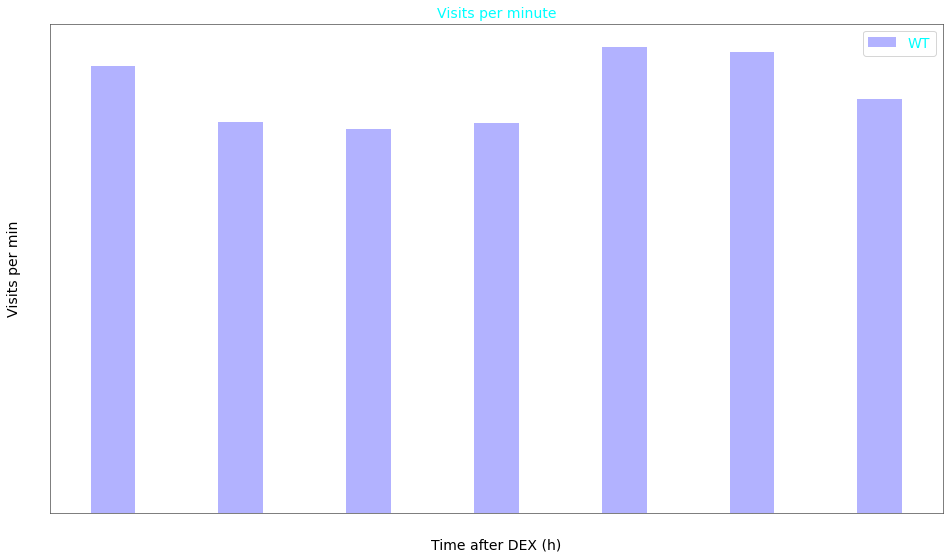

In [60]:
plt.title('Visits per minute')


labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations

plt.bar(x, 100*(np.array(CB_KO_mean))/np.array(CB_mean), width,# yerr=np.array(CB_std),
        label='WT', color='b', error_kw=dict(ecolor='cyan', lw=5, capsize=15, capthick=5), alpha=0.3)

#plt.yscale('log')
plt.xlabel('Time after DEX (h)')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48'])
plt.ylabel('Visits per min')
plt.legend()

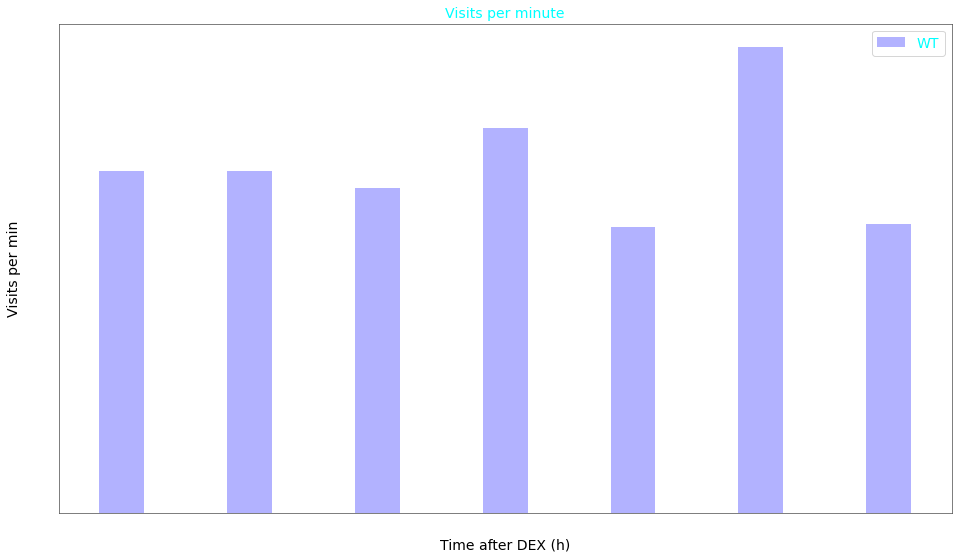

In [61]:
plt.title('Visits per minute')


labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations

plt.bar(x, 100*(np.array(CBC1_KO_mean))/np.array(CBC1_mean), width,# yerr=np.array(CB_std),
        label='WT', color='b', error_kw=dict(ecolor='cyan', lw=5, capsize=15, capthick=5), alpha=0.3)

#plt.yscale('log')
plt.xlabel('Time after DEX (h)')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48'])
plt.ylabel('Visits per min')
plt.legend()

In [ ]:
plt.title('Visits per minute')


labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations

plt.bar(x, 100*np.array(CB_KO_mean)/np.array(CB_mean), width,# yerr=np.array(CB_std),
        label='WT', color='b', error_kw=dict(ecolor='cyan', lw=5, capsize=15, capthick=5), alpha=0.3)

#plt.yscale('log')
plt.xlabel('Time after DEX (h)')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48'])
plt.ylabel('Visits per min')
plt.legend()

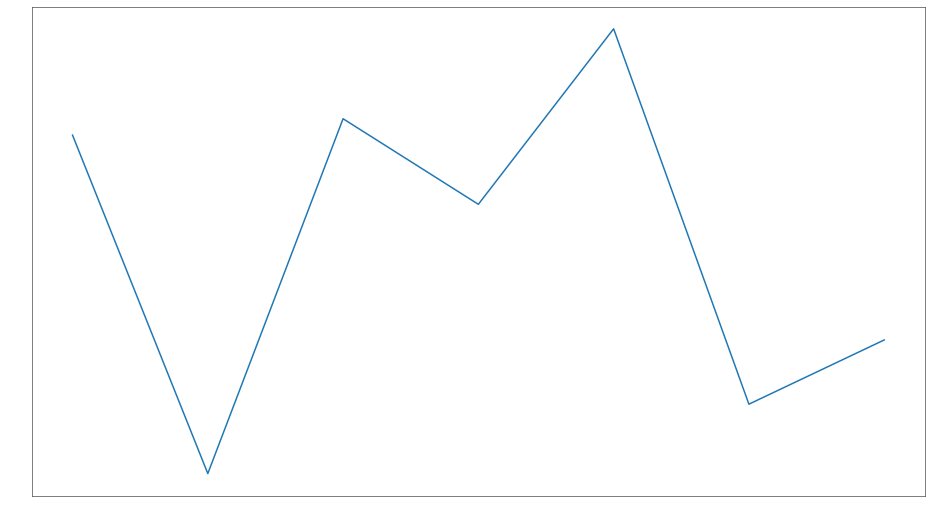

In [71]:
CB_diffs = 100 * (np.array(CB_mean) - np.array(CB_KO_mean)) / np.array(CB_mean)

plt.plot([24, 28, 32, 36, 40, 44, 48], CB_diffs)

100%|██████████| 7/7 [00:00<00:00, 56.63it/s]


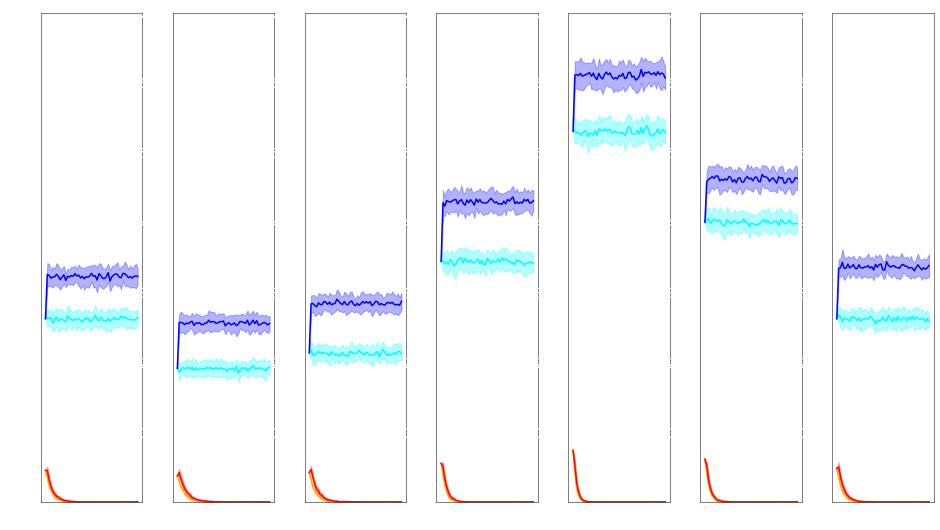

In [327]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=7, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 700 #110
axs =  [None] * samples
for n in tqdm(range(samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3]['y'], averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='cyan', alpha=0.3)
    
    axs[n].plot(averaged_data_grid[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid[n]['data'][m['CBC1S']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid[n]['data'][m['CBC1S']*3]['y'], averaged_data_grid[n]['data'][m['CBC1S']*3+2]['y'], color='orange', alpha=0.3)
    
    axs[n].plot(averaged_data_grid_KO[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBS']*3+1]['y'], color='blue')
    axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBS']*3]['y'], averaged_data_grid_KO[n]['data'][m['CBS']*3+2]['y'], color='blue', alpha=0.3)
    
    axs[n].plot(averaged_data_grid_KO[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBC1S']*3+1]['y'], color='red')
    axs[n].fill_between(averaged_data_grid_KO[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid_KO[n]['data'][m['CBC1S']*3]['y'], averaged_data_grid_KO[n]['data'][m['CBC1S']*3+2]['y'], color='red', alpha=0.3)
    #axs[n].plot(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3+1]['y'], color='orange')
    #axs[n].fill_between(averaged_data_grid[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid[n]['data'][m['CBS']*3]['y'], averaged_data_grid[n]['data'][m['CBS']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

In [328]:
time_points = [24, 28, 32, 36, 40, 44, 48]
save_out_array = np.array([CB_mean, CB_std, CB_KO_mean, CB_KO_std, CBC1_mean, CBC1_std, CBC1_KO_mean, CBC1_KO_std]).transpose()
columns = ['CB_mean', 'CB_std', 'CB_KO_mean', 'CB_KO_std', 'CBC1_mean', 'CBC1_std', 'CBC1_KO_mean', 'CBC1_KO_std']

df_save = pd.DataFrame(save_out_array, columns=columns, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs/20-7-21 Visits per min time course WT vs PER2 KO 600s.xlsx")

In [127]:
k_on*10

0.178123

In [139]:
kOFF_peak = 1/2.359 # s T32 from Bmal1xCry1 timecourse
kOFF_trough = 1/3.038 # s T40 from Bmal1xCry1 timecourse
kOFF_trough

0.32916392363396973

In [140]:
kOFF_peak

0.42390843577787196

In [131]:
R_off = 1.98410e+01 # +/- 4.37389e-02 (0.2 %)

In [58]:
DBP_kOFF = 1 / 8
DBP_kOFF

0.125

## PER2 range

In [33]:
PER_samples = 7
PERs = np.array([0, 5, 10, 15, 20, 50, 100]) # np.linspace(0, 100, num=PER_samples)

initial_concentrations_PER = np.array([np.array([0.0]*14)]*PER_samples)
initial_concentrations_PER[:, var['S']] = S_conc
initial_concentrations_PER[:, var['B']] = Bmal1(tps)[4]
initial_concentrations_PER[:, var['C']] = Clock[4]
initial_concentrations_PER[:, var['C1']] = Cry1(tps)[4]
initial_concentrations_PER[:, var['P2']] = PERs
initial_concentrations_PER = initial_concentrations_PER.astype('float64')

ode_model_PER = DNA_binding_model_B1(PER_samples, initial_concentrations_PER, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, np.array([kd_CB_C1s(tps)[4]]*PER_samples), cores=20)

result_PER = ode_model_PER.full_simulate(fitted_params)
kOFF_sim_PER = result_PER[:, 0]
equilibrium_conc_sim_PER = np.array([el[1:] for el in result_PER])
kOFF_sim_PER

2

array([0.2684237 , 0.34201206, 0.40757503, 0.4662574 , 0.51901032,
       0.74775269, 0.95150664])

In [34]:
1/kOFF_sim_PER

array([3.72545345, 2.92387352, 2.45353597, 2.14473809, 1.92674396,
       1.33734056, 1.05096482])

In [35]:
equilibrium_conc_sim_PER.shape

(7, 14)

In [52]:
smod_grid_PER = [None] * PER_samples
trajectories = 5
sim_time = 60*60 #2 * 60 * 60 

raw_data_grid_PER = [None] * PER_samples
averaged_data_grid_PER = [None] * PER_samples
distributions_data_grid_PER = [None] * PER_samples

#time_per_time = (39 / 1) / 60
print('Estimated simulation time = {:0.2f} mins'.format(PER_samples * time_per_time * sim_time *trajectories/60))

#@discord_sender(webhook_url=webhook_url)
def run_PER_sim():
    for n in tqdm(range(PER_samples)):
        
        params = [
            {'name': 'k_on', 'value': fitted_params[0] / fac},     # nM^-1 s^-1
            {'name': 'k_off', 'value': kOFF_sim_PER[n]},         # s^-1
        ]
        
        species = [
            {'name': 'S', 'value': fac*equilibrium_conc_sim[4, var['S']]-1},
            {'name': 'CBS', 'value': fac*equilibrium_conc_sim[4, var['CBS']]},
            {'name': 'CB', 'value': fac*equilibrium_conc_sim[4, var['CB']]},
            {'name': 'CBC1', 'value': fac*equilibrium_conc_sim[4, var['CBC1']]},
            {'name': 'CBC1S', 'value': fac*equilibrium_conc_sim_[4, var['CBC1S']]},
            {'name': 'marked_gene', 'value': 1},
        ]
        
    
        smod_grid_PER[n] = run_stochpy("D.1c simple model tracked binding and first arrivals",
                                        trajectories, 
                                        sim_time, 
                                        params=params, 
                                        species=species,  
                                        mode='time',
                                        method='Direct',
                                        marked_genes=None)
        # Calculate the average results straight afterwards as only the last stochastic sim is saved in the temp folder
        raw_data_grid_PER[n], averaged_data_grid_PER[n], distributions_data_grid_PER[n] = generate_stochastic_plots(smod_grid_PER[n], multiple_trajectories=int(trajectories > 1))
    return 
    
run_PER_sim()

  0%|          | 0/7 [00:00<?, ?it/s]

Estimated simulation time = 45.82 mins


NameError: name 'equilibrium_conc_sim_' is not defined

100%|██████████| 7/7 [00:00<00:00, 61.87it/s]


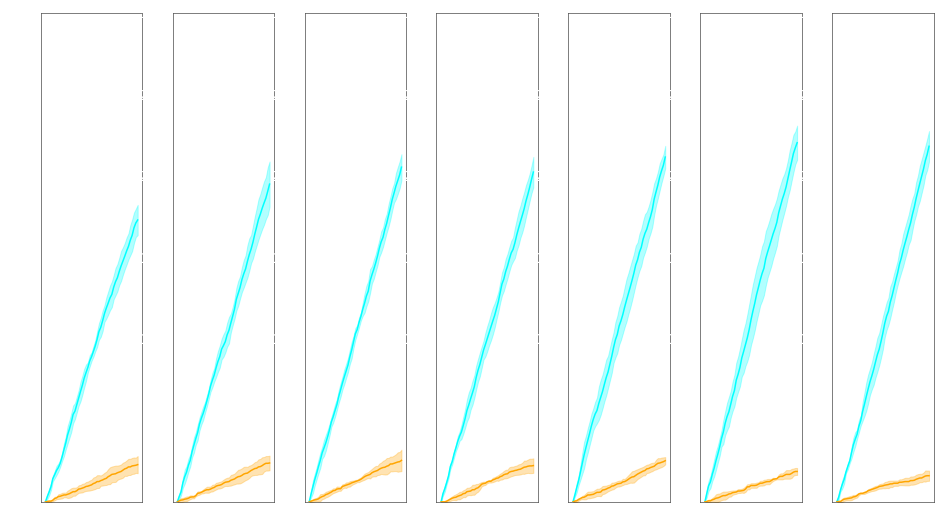

In [41]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=PER_samples, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 300
axs =  [None] * PER_samples
for n in tqdm(range(PER_samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid_PER[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CB_bind']*3+1]['y'], color='cyan')
    #axs[n].plot(raw_data_grid_kOFF[n]['data'][m['CB_bind']]['x'], raw_data_grid_kOFF[n]['data'][m['CB_bind']]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid_PER[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CB_bind']*3]['y'], averaged_data_grid_PER[n]['data'][m['CB_bind']*3+2]['y'], color='cyan', alpha=0.3)
    axs[n].plot(averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3]['y'], averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])

plt.subplots_adjust(wspace=.3, hspace=.5)

100%|██████████| 7/7 [00:00<00:00, 66.73it/s]


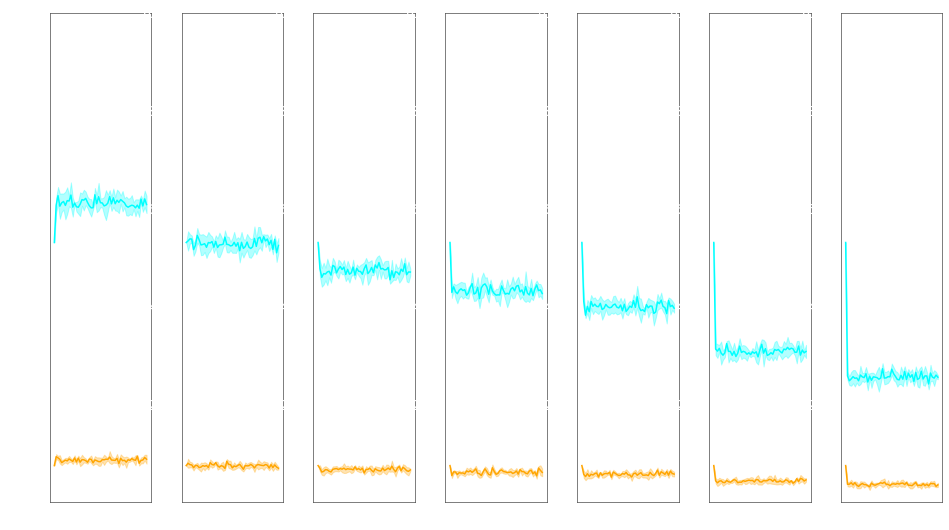

In [359]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=PER_samples, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 1000
axs =  [None] * PER_samples
for n in tqdm(range(PER_samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid_PER[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CBS']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid_PER[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CBS']*3]['y'], averaged_data_grid_PER[n]['data'][m['CBS']*3+2]['y'], color='cyan', alpha=0.3)
    axs[n].plot(averaged_data_grid_PER[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CBC1S']*3+1]['y'] + averaged_data_grid_PER[n]['data'][m['CBC1S0']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid_PER[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid_PER[n]['data'][m['CBC1S']*3]['y'] + averaged_data_grid_PER[n]['data'][m['CBC1S0']*3]['y'], averaged_data_grid_PER[n]['data'][m['CBC1S']*3+2]['y'] + averaged_data_grid_PER[n]['data'][m['CBC1S0']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    #axs[n].set_xticks([0, 60, 120, 180])

plt.subplots_adjust(wspace=.3, hspace=.5)

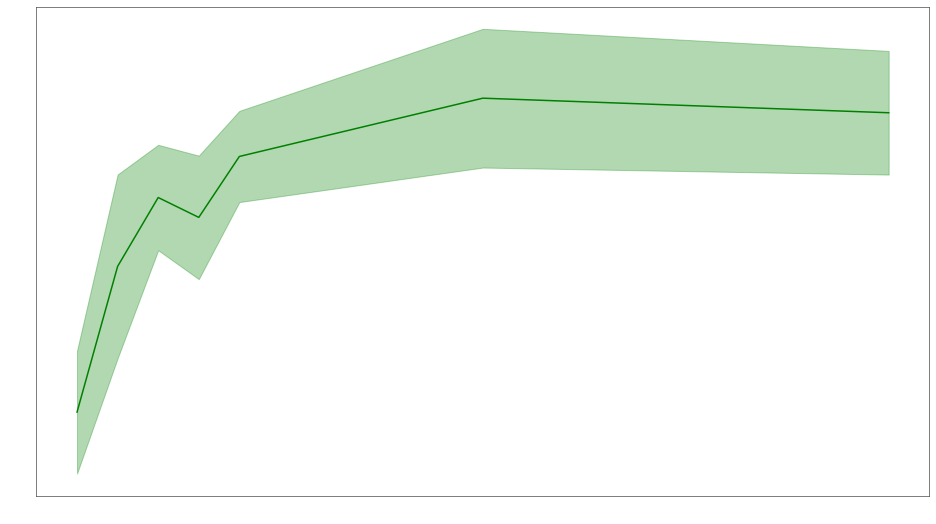

In [48]:
per2_visits_per_min_CB = np.zeros(PER_samples)
per2_visits_per_min_CB_std = np.zeros(PER_samples)
per2_visits_per_min_CBC1 = np.zeros(PER_samples)
per2_visits_per_min_CBC1_std = np.zeros(PER_samples)

per2_SO_CB = np.zeros(PER_samples)
per2_SO_CB_std = np.zeros(PER_samples)
per2_SO_CBC1 = np.zeros(PER_samples)
per2_SO_CBC1_std = np.zeros(PER_samples)

for n in range(PER_samples):
    per2_visits_per_min_CB[n] = 60 * averaged_data_grid_PER[n]['data'][m['CB_bind']*3+1]['y'][-1] / sim_time
    per2_visits_per_min_CB_std[n] = 60 * (averaged_data_grid_PER[n]['data'][m['CB_bind']*3+1]['y'][-1] - averaged_data_grid_PER[n]['data'][m['CB_bind']*3]['y'][-1]) / sim_time
    per2_visits_per_min_CBC1[n] = 60 * averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3+1]['y'][-1] / sim_time
    per2_visits_per_min_CBC1_std[n] = 60 * (averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3+1]['y'][-1] - averaged_data_grid_PER[n]['data'][m['CBC1_bind']*3]['y'][-1]) / sim_time
    
    per2_SO_CB[n] = averaged_data_grid_PER[n]['data'][m['CBS']*3+1]['y'][-1] / 3435
    per2_SO_CB_std[n] = (averaged_data_grid_PER[n]['data'][m['CBS']*3+1]['y'][-1] - averaged_data_grid_PER[n]['data'][m['CBS']*3]['y'][-1]) / 3435
    per2_SO_CBC1[n] = averaged_data_grid_PER[n]['data'][m['CBC1S0']*3+1]['y'][-1] / sim_time
    per2_SO_CBC1_std[n] = (averaged_data_grid_PER[n]['data'][m['CBC1S0']*3+1]['y'][-1] - averaged_data_grid_PER[n]['data'][m['CBC1S0']*3]['y'][-1]) / 3435

plt.plot(PERs, per2_visits_per_min_CB, color='green')
#plt.xscale('log')
plt.fill_between(PERs, per2_visits_per_min_CB - per2_visits_per_min_CB_std, per2_visits_per_min_CB + per2_visits_per_min_CB_std, color='green', alpha=0.3)

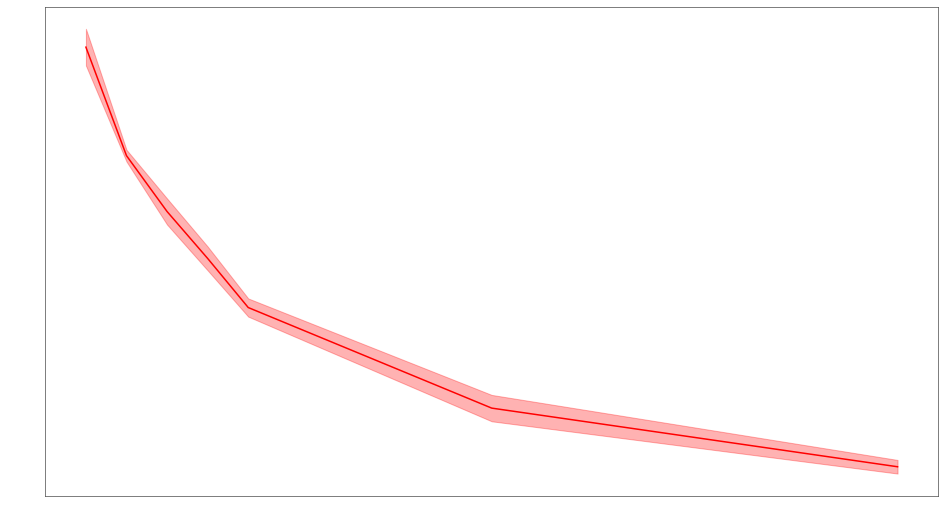

In [49]:
plt.plot(PERs, per2_SO_CB, color='red')
#plt.xscale('log')
plt.fill_between(PERs, per2_SO_CB - per2_SO_CB_std, per2_SO_CB + per2_SO_CB_std, color='red', alpha=0.3)

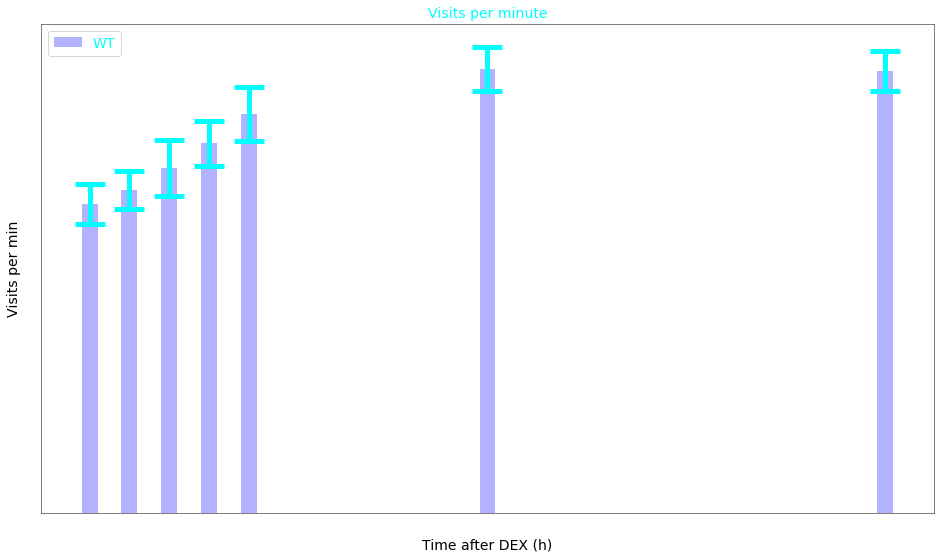

In [361]:
plt.title('Visits per minute')


labels = PERs #['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']

plt.bar(PERs, per2_visits_per_min_CB, 2, yerr=np.array(per2_visits_per_min_CB_std),
        label='WT', color='b', error_kw=dict(ecolor='cyan', lw=5, capsize=15, capthick=5), alpha=0.3)

#plt.yscale('log')
plt.xlabel('Time after DEX (h)')
#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48'])
plt.ylabel('Visits per min')
plt.legend()

In [50]:
#save_out_array = np.array([per2_visits_per_min_CB, per2_visits_per_min_CB_std, per2_visits_per_min_CBC1, per2_visits_per_min_CBC1_std]).transpose()
#columns = ['CB', 'CB_std', 'CBC1', 'CBC1_std']

save_out_array = np.array([per2_visits_per_min_CB, 
                           per2_visits_per_min_CB_std, 
                           per2_visits_per_min_CBC1, 
                           per2_visits_per_min_CBC1_std,
                           per2_SO_CB,
                           per2_SO_CB_std,
                           per2_SO_CBC1,
                           per2_SO_CBC1_std]).transpose()
columns = ['CB VPM', 'CB_std VPM', 'CBC1 VPM', 'CBC1_std VPM', 'CB SO', 'CB_std SO', 'CBC1 SO', 'CBC1_std SO']

df_save = pd.DataFrame(save_out_array, columns=columns, index=PERs)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs/13-9-21 Visits per min and SO over Per2 conc.xlsx")

## CRY1:PER2 

In [38]:
CRY_PER_samples = 7
CRY_PERs = np.array([0, 5, 10, 15, 20, 50, 100]) # np.linspace(0, 100, num=PER_samples)

initial_concentrations_CRY_PER = np.array([np.array([0.0]*14)]*CRY_PER_samples)
initial_concentrations_CRY_PER[:, var['S']] = S_conc
initial_concentrations_CRY_PER[:, var['B']] = Bmal1(tps)[4]
initial_concentrations_CRY_PER[:, var['C']] = Clock[4]
initial_concentrations_CRY_PER[:, var['C1']] = CRY_PERs
initial_concentrations_CRY_PER[:, var['P2']] = PERs
initial_concentrations_CRY_PER = initial_concentrations_CRY_PER.astype('float64')

ode_model_CRY_PER = DNA_binding_model_B1(CRY_PER_samples, initial_concentrations_CRY_PER, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, np.array([kd_CB_C1s(tps)[4]]*CRY_PER_samples), cores=20)

result_CRY_PER = ode_model_CRY_PER.full_simulate(fitted_params)
kOFF_sim_CRY_PER = result_CRY_PER[:, 0]
equilibrium_conc_sim_CRY_PER = np.array([el[1:] for el in result_CRY_PER])
kOFF_sim_CRY_PER

3

array([0.2684237 , 0.29920453, 0.37499577, 0.47790935, 0.59629509,
       1.34182133, 2.21801043])

In [39]:
1/kOFF_sim_CRY_PER

array([3.72545345, 3.34219539, 2.66669676, 2.09244705, 1.67702204,
       0.7452557 , 0.45085451])

In [40]:
smod_grid_CRY_PER = [None] * CRY_PER_samples
trajectories = 5
sim_time = 60*60 #2 * 60 * 60 

raw_data_grid_CRY_PER = [None] * CRY_PER_samples
averaged_data_grid_CRY_PER = [None] * CRY_PER_samples
distributions_data_grid_CRY_PER = [None] * CRY_PER_samples

#time_per_time = (39 / 1) / 60
print('Estimated simulation time = {:0.2f} mins'.format(CRY_PER_samples * time_per_time * sim_time *trajectories/60))

#@discord_sender(webhook_url=webhook_url)
def run_CRY_PER_sim():
    for n in tqdm(range(CRY_PER_samples)):
        
        params = [
            {'name': 'k_on', 'value': fitted_params[0] / fac},     # nM^-1 s^-1
            {'name': 'k_off', 'value': kOFF_sim_PER[n]},         # s^-1
        ]
        
        species = [
            {'name': 'S', 'value': fac*equilibrium_conc_sim_CRY_PER[n, var['S']]-1},
            {'name': 'CBS', 'value': fac*equilibrium_conc_sim_CRY_PER[n, var['CBS']]},
            {'name': 'CB', 'value': fac*equilibrium_conc_sim_CRY_PER[n, var['CB']]},
            {'name': 'CBC1', 'value': fac*equilibrium_conc_sim_CRY_PER[n, var['CBC1']]},
            {'name': 'CBC1S', 'value': fac*equilibrium_conc_sim_CRY_PER[n, var['CBC1S']]},
            {'name': 'marked_gene', 'value': 1},
        ]
        
    
        smod_grid_CRY_PER[n] = run_stochpy("D.1c simple model tracked binding and first arrivals",
                                        trajectories, 
                                        sim_time, 
                                        params=params, 
                                        species=species,  
                                        mode='time',
                                        method='Direct',
                                        marked_genes=None)
        # Calculate the average results straight afterwards as only the last stochastic sim is saved in the temp folder
        raw_data_grid_CRY_PER[n], averaged_data_grid_CRY_PER[n], distributions_data_grid_CRY_PER[n] = generate_stochastic_plots(smod_grid_CRY_PER[n], multiple_trajectories=int(trajectories > 1))
    return 
    
run_CRY_PER_sim()

  0%|          | 0/7 [00:00<?, ?it/s]

Estimated simulation time = 45.82 mins
Simulating...


 14%|█▍        | 1/7 [04:26<26:39, 266.55s/it]

Simulating...


 29%|██▊       | 2/7 [09:20<23:33, 282.71s/it]

Simulating...


 43%|████▎     | 3/7 [14:13<19:08, 287.15s/it]

Simulating...


 57%|█████▋    | 4/7 [19:11<14:35, 291.82s/it]

Simulating...


 71%|███████▏  | 5/7 [24:01<09:41, 290.98s/it]

Simulating...


 86%|████████▌ | 6/7 [28:49<04:49, 289.99s/it]

Simulating...


100%|██████████| 7/7 [33:00<00:00, 282.95s/it]


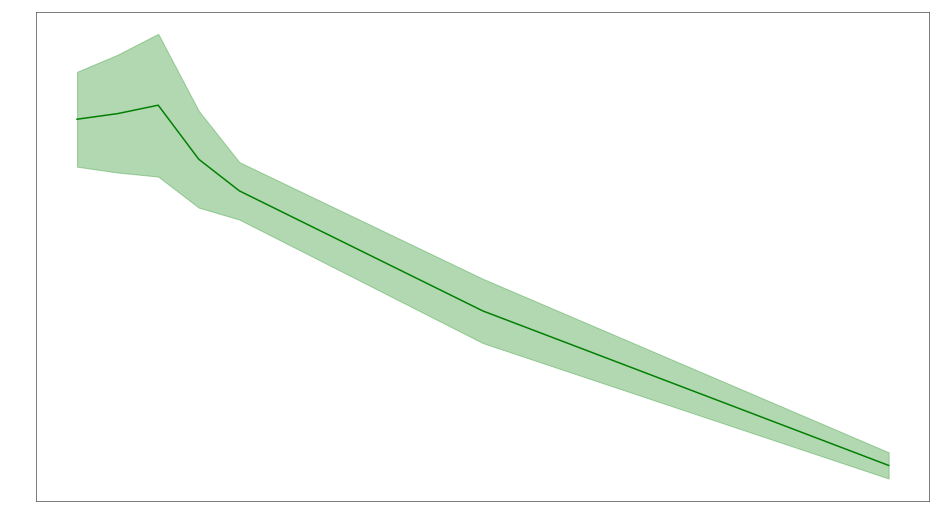

In [44]:
CRY_PER_visits_per_min_CB = np.zeros(CRY_PER_samples)
CRY_PER_visits_per_min_CB_std = np.zeros(CRY_PER_samples)
CRY_PER_visits_per_min_CBC1 = np.zeros(CRY_PER_samples)
CRY_PER_visits_per_min_CBC1_std = np.zeros(CRY_PER_samples)

for n in range(CRY_PER_samples):
    CRY_PER_visits_per_min_CB[n] = 60 * averaged_data_grid_CRY_PER[n]['data'][m['CB_bind']*3+1]['y'][-1] / sim_time
    CRY_PER_visits_per_min_CB_std[n] = 60 * (averaged_data_grid_CRY_PER[n]['data'][m['CB_bind']*3+1]['y'][-1] - averaged_data_grid_CRY_PER[n]['data'][m['CB_bind']*3]['y'][-1]) / sim_time
    CRY_PER_visits_per_min_CBC1[n] = 60 * averaged_data_grid_CRY_PER[n]['data'][m['CBC1_bind']*3+1]['y'][-1] / sim_time
    CRY_PER_visits_per_min_CBC1_std[n] = 60 * (averaged_data_grid_CRY_PER[n]['data'][m['CBC1_bind']*3+1]['y'][-1] - averaged_data_grid_CRY_PER[n]['data'][m['CBC1_bind']*3]['y'][-1]) / sim_time

plt.plot(CRY_PERs, CRY_PER_visits_per_min_CB, color='green')
#plt.xscale('log')
plt.fill_between(CRY_PERs, CRY_PER_visits_per_min_CB - CRY_PER_visits_per_min_CB_std, CRY_PER_visits_per_min_CB + CRY_PER_visits_per_min_CB_std, color='green', alpha=0.3)

## Figure S8 I grid 

In [43]:
smod_grid_N_K = [[None, None, None], [None, None, None], [None, None, None]]
raw_data_grid_N_K = [[None, None, None], [None, None, None], [None, None, None]]
averaged_data_grid_N_K = [[None, None, None], [None, None, None], [None, None, None]]
distributions_data_grid_N_K = [[None, None, None], [None, None, None], [None, None, None]]

trajectories = 30
sim_time = 10 * 60 #10 * 60 #1 * 60 * 60

print('Estimated simulation time = {:0.2f} mins'.format(time_per_time * 9 * sim_time *trajectories/60))

Ns = [1, 2, 4]
Ks = [1, 2, 4]
def run_grid_sim():
    for n in tqdm(range(3)):
        for k in tqdm(range(3)):
            params = [
                {'name': 'k_on', 'value': fitted_params[0] / fac},     # nM^-1 s^-1
                {'name': 'k_off', 'value': kOFF_sim[Ks[k]]},         # s^-1
            ]
    
            species = [
                {'name': 'S', 'value': fac*equilibrium_conc_sim[Ns[n], var['S']]-1},
                {'name': 'CBS', 'value': fac*equilibrium_conc_sim[Ns[n], var['CBS']]},
                {'name': 'CB', 'value': fac*equilibrium_conc_sim[Ns[n], var['CB']]},
                {'name': 'CBC1', 'value': fac*equilibrium_conc_sim[Ns[n], var['CBC1']]},
                {'name': 'CBC1S', 'value': fac*equilibrium_conc_sim[Ns[n], var['CBC1S']]},
                {'name': 'marked_gene', 'value': 1},
            ]
            
            smod_grid_N_K[n][k] = run_stochpy("D.1c simple model tracked binding and first arrivals", 
                                              trajectories, 
                                              sim_time, 
                                              params=params, 
                                              species=species,  
                                              mode='time',
                                              method='Direct',
                                              marked_genes=None)
            raw_data_grid_N_K[n][k], averaged_data_grid_N_K[n][k], distributions_data_grid_N_K[n][k] = generate_stochastic_plots(smod_grid_N_K[n][k], multiple_trajectories=int(trajectories > 1))
    return 

run_grid_sim()

  0%|          | 0/3 [00:00<?, ?it/s]

Estimated simulation time = 58.91 mins
Simulating...



 33%|███▎      | 1/3 [01:59<03:59, 119.52s/it]

Simulating...



 67%|██████▋   | 2/3 [03:57<01:58, 118.77s/it]

Simulating...



  0%|          | 0/3 [00:00<?, ?it/s]

Simulating...



 33%|███▎      | 1/3 [02:11<04:23, 131.85s/it]

Simulating...



 67%|██████▋   | 2/3 [04:23<02:11, 131.93s/it]

Simulating...



  0%|          | 0/3 [00:00<?, ?it/s]

Simulating...



 33%|███▎      | 1/3 [04:33<09:07, 273.65s/it]

Simulating...



 67%|██████▋   | 2/3 [09:06<04:33, 273.36s/it]

Simulating...



100%|██████████| 3/3 [25:36<00:00, 512.10s/it]


  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'averaged_data_grid_N_K' is not defined

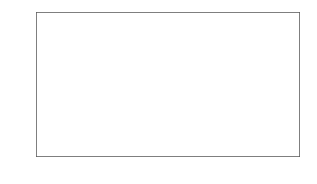

In [371]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

kOFF_labels = ['T28', 'T32', 'T40']
n_labels = ['T28', 'T32', 'T40']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 40
axs =  [[None, None, None], [None, None, None], [None, None, None]]
for n in tqdm(range(3)):
    for k in tqdm(range(3)):
        axs[n][k] = fig_grid.add_subplot(spec_grid[n, k])
        axs[n][k].plot(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['y'], color='cyan')
        axs[n][k].fill_between(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']]['y'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+2]['y'], color='cyan', alpha=0.3)
        axs[n][k].plot(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['y'], color='orange')
        axs[n][k].fill_between(averaged_data_grid_N_K[n][k]['data'][3*10+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']]['y'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+2]['y'], color='orange', alpha=0.3)
        axs[n][k].set_xlim([0, x_axis_lim])
        axs[n][k].set_ylim([0, y_axis_lim])
        axs[n][k].set_title('N: {} K:{}'.format(n_labels[n], kOFF_labels[k]))
        if n == 2:
            axs[n][k].set_xlabel(kOFF_labels[k])
        if k == 0:
            axs[n][k].set_ylabel(n_labels[n])

plt.subplots_adjust(wspace=.3, hspace=.5)

In [45]:
V_small_vol = 250E-15 
fac_small_vol = 1E-9 * N_A * V_small_vol

S = 3436 # Specific Binding sites
S_conc_small_vol = S * 1E9 / (N_A * V_small_vol)
print('S_small = {:} nM'.format(S_conc_small_vol))

initial_concentrations_small_vol = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_small_vol[:, var['S']] = S_conc_small_vol
initial_concentrations_small_vol[:, var['B']] = Bmal1(tps)
initial_concentrations_small_vol[:, var['C']] = Clock
initial_concentrations_small_vol[:, var['C1']] = Cry1(tps)
initial_concentrations_small_vol[:, var['P2']] = Per2(tps)
initial_concentrations_small_vol = initial_concentrations_small_vol.astype('float64')

ode_model_small_vol = DNA_binding_model_B1(samples, initial_concentrations_small_vol, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s(tps), cores=20)

result_small_vol = ode_model_small_vol.full_simulate(fitted_params)
kOFF_sim_small_vol = result_small_vol[:, 0]
equilibrium_conc_sim_small_vol = np.array([el[1:] for el in result_small_vol])
kOFF_sim_small_vol

S_small = 22.822982397874462 nM
3

array([0.37389679, 0.42191621, 0.41951109, 0.38157633, 0.34104739,
       0.3391848 , 0.39797867])

In [84]:
equilibrium_conc_sim_small_vol[:, var['CBS']] * 1E-9 * N_A * V_small_vol

array([226.67360606, 168.41143663, 186.86973377, 296.04850051,
       446.83938229, 339.06786154, 227.93562202])

In [46]:
smod_grid_N_K_small_vol = [[None, None, None], [None, None, None], [None, None, None]]
raw_data_grid_N_K_small_vol = [[None, None, None], [None, None, None], [None, None, None]]
averaged_data_grid_N_K_small_vol = [[None, None, None], [None, None, None], [None, None, None]]
distributions_data_grid_N_K_small_vol = [[None, None, None], [None, None, None], [None, None, None]]

trajectories = 30
sim_time = 10 * 60 #10 * 60 #1 * 60 * 60

print('Estimated simulation time = {:0.2f} mins'.format(time_per_time * 9 * sim_time *trajectories/60))

Ns = [1, 2, 4]
Ks = [1, 2, 4]
def run_grid_sim_small_vol():
    for n in tqdm(range(3)):
        for k in tqdm(range(3)):
            params = [
                {'name': 'k_on', 'value': fitted_params[0] / fac_small_vol},     # nM^-1 s^-1
                {'name': 'k_off', 'value': kOFF_sim_small_vol[Ks[k]]},         # s^-1
            ]
    
            species = [
                {'name': 'S', 'value': fac_small_vol*equilibrium_conc_sim_small_vol[Ns[n], var['S']]-1},
                {'name': 'CBS', 'value': fac_small_vol*equilibrium_conc_sim_small_vol[Ns[n], var['CBS']]},
                {'name': 'CB', 'value': fac_small_vol*equilibrium_conc_sim_small_vol[Ns[n], var['CB']]},
                {'name': 'CBC1', 'value': fac_small_vol*equilibrium_conc_sim_small_vol[Ns[n], var['CBC1']]},
                {'name': 'CBC1S', 'value': fac_small_vol*equilibrium_conc_sim_small_vol[Ns[n], var['CBC1S']]},
                {'name': 'marked_gene', 'value': 1},
            ]
            
            smod_grid_N_K_small_vol[n][k] = run_stochpy("D.1c simple model tracked binding and first arrivals", 
                                                        trajectories, 
                                                        sim_time, 
                                                        params=params, 
                                                        species=species,  
                                                        mode='time',
                                                        method='Direct',
                                                        marked_genes=None)
            raw_data_grid_N_K_small_vol[n][k], averaged_data_grid_N_K_small_vol[n][k], distributions_data_grid_N_K_small_vol[n][k] = generate_stochastic_plots(smod_grid_N_K_small_vol[n][k], multiple_trajectories=int(trajectories > 1))
    return 

run_grid_sim_small_vol()

  0%|          | 0/3 [00:00<?, ?it/s]

Estimated simulation time = 58.91 mins
Simulating...



 33%|███▎      | 1/3 [01:55<03:50, 115.17s/it]

Simulating...



 67%|██████▋   | 2/3 [03:48<01:54, 114.36s/it]

Simulating...



  0%|          | 0/3 [00:00<?, ?it/s]

Simulating...



 33%|███▎      | 1/3 [01:56<03:53, 116.87s/it]

Simulating...



 67%|██████▋   | 2/3 [03:51<01:55, 115.82s/it]

Simulating...



  0%|          | 0/3 [00:00<?, ?it/s]

Simulating...



 33%|███▎      | 1/3 [04:05<08:10, 245.00s/it]

Simulating...



 67%|██████▋   | 2/3 [08:08<04:03, 243.84s/it]

Simulating...



100%|██████████| 3/3 [22:47<00:00, 455.87s/it]


100%|██████████| 3/3 [00:00<00:00, 61.79it/s]

100%|██████████| 3/3 [00:00<00:00, 19.59it/s]


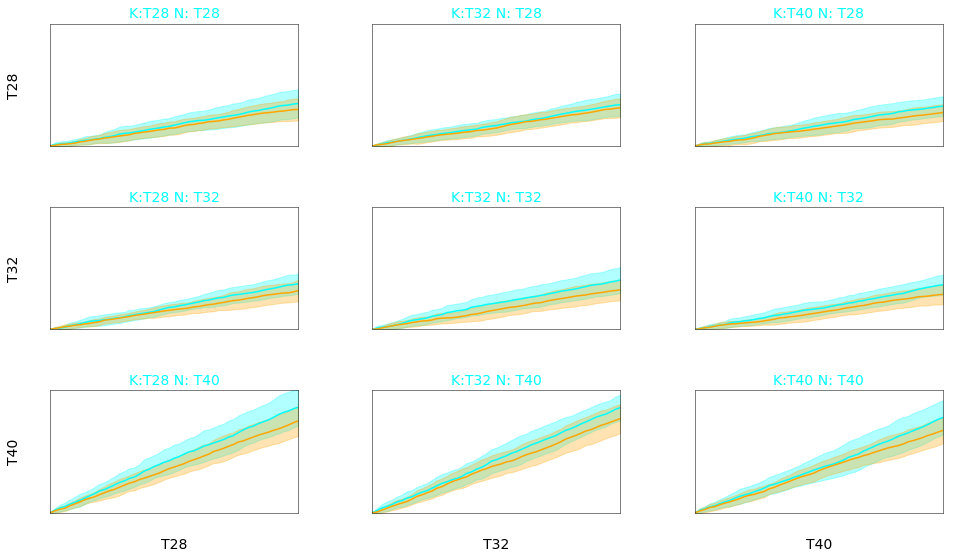

In [59]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

kOFF_labels = ['T28', 'T32', 'T40']
n_labels = ['T28', 'T32', 'T40']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 40
axs =  [[None, None, None], [None, None, None], [None, None, None]]
for n in tqdm(range(3)):
    for k in tqdm(range(3)):
        axs[n][k] = fig_grid.add_subplot(spec_grid[n, k])
        axs[n][k].plot(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['y'], color='cyan')
        axs[n][k].fill_between(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']]['y'], averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+2]['y'], color='cyan', alpha=0.3)
        axs[n][k].plot(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']+1]['x'], averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']+1]['y'], color='orange')
        axs[n][k].fill_between(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']+1]['x'], averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']]['y'], averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']+2]['y'], color='orange', alpha=0.3)
        axs[n][k].set_xlim([0, x_axis_lim])
        axs[n][k].set_ylim([0, y_axis_lim])
        axs[n][k].set_title('K:{} N: {}'.format(kOFF_labels[k], n_labels[n]))
        if n == 2:
            axs[n][k].set_xlabel(kOFF_labels[k])
        if k == 0:
            axs[n][k].set_ylabel(n_labels[n])

plt.subplots_adjust(wspace=.3, hspace=.5)

100%|██████████| 3/3 [00:00<00:00, 61.95it/s]

100%|██████████| 3/3 [00:00<00:00, 19.15it/s]


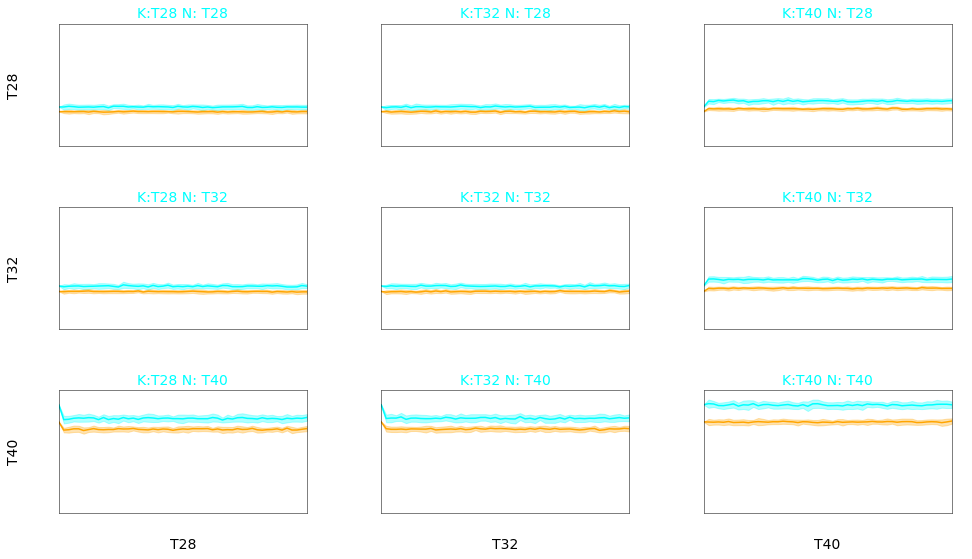

In [58]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

kOFF_labels = ['T28', 'T32', 'T40']
n_labels = ['T28', 'T32', 'T40']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 600
axs =  [[None, None, None], [None, None, None], [None, None, None]]
for n in tqdm(range(3)):
    for k in tqdm(range(3)):
        axs[n][k] = fig_grid.add_subplot(spec_grid[n, k])
        axs[n][k].plot(averaged_data_grid_N_K[n][k]['data'][3*m['CBS']+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CBS']+1]['y'], color='cyan')
        axs[n][k].fill_between(averaged_data_grid_N_K[n][k]['data'][3*m['CBS']+1]['x'], averaged_data_grid_N_K[n][k]['data'][3*m['CBS']]['y'], averaged_data_grid_N_K[n][k]['data'][3*m['CBS']+2]['y'], color='cyan', alpha=0.3)
        axs[n][k].plot(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']+1]['x'], averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']+1]['y'], color='orange')
        axs[n][k].fill_between(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']+1]['x'], averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']]['y'], averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']+2]['y'], color='orange', alpha=0.3)
        axs[n][k].set_xlim([0, x_axis_lim])
        axs[n][k].set_ylim([0, y_axis_lim])
        axs[n][k].set_title('K:{} N: {}'.format(kOFF_labels[k], n_labels[n]))
        if n == 2:
            axs[n][k].set_xlabel(kOFF_labels[k])
        if k == 0:
            axs[n][k].set_ylabel(n_labels[n])

plt.subplots_adjust(wspace=.3, hspace=.5)

In [56]:
end_index = -1 #100000

save_out_array = []
save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['x'][:end_index])
header_string = 'time (s)'
time_labels = ['T28', 'T32', 'T40']

for n in tqdm(range(3)):
    for k in tqdm(range(3)):
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+1]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CB_bind']+2]['y'][:end_index].tolist())
        
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CBC1_bind']+1]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CBC1_bind']]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CBC1_bind']+2]['y'][:end_index].tolist())
        
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB mean' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB lower bound (-std) (N={:})'.format(30) 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB upper bound (+std) (N={:})'.format(30) 
        
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 mean' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 lower bound (-std) (N={:})'.format(30) 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 upper bound (+std) (N={:})'.format(30) 
        
print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '27-7-21 Correct volume GRID vists.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 3/3 [00:00<00:00, 18477.11it/s]

100%|██████████| 3/3 [00:00<00:00, 24916.66it/s]

100%|██████████| 3/3 [00:00<00:00, 320.79it/s]

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.20000000e+01  4.33333333e-01 -2.34166146e-01 ...  1.66666667e-01
  -2.86715684e-01  6.20049017e-01]
 [ 2.40000000e+01  6.00000000e-01 -2.00000000e-01 ...  2.00000000e-01
  -2.76095229e-01  6.76095229e-01]
 ...
 [ 5.64000000e+02  1.32000000e+01  8.66568638e+00 ...  3.80000000e+00
   1.61825758e+00  5.98174242e+00]
 [ 5.76000000e+02  1.33333333e+01  8.71212618e+00 ...  3.86666667e+00
   1.61969339e+00  6.11363994e+00]
 [ 5.88000000e+02  1.36666667e+01  9.04545951e+00 ...  3.96666667e+00
   1.62169569e+00  6.31163764e+00]]


In [52]:
end_index = -1 #100000

save_out_array = []
save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CBS']+1]['x'][:end_index])
header_string = 'time (s)'
time_labels = ['T28', 'T32', 'T40']

for n in tqdm(range(3)):
    for k in tqdm(range(3)):
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CBS']+1]['y'][:end_index].tolist())
        save_out_array.append((averaged_data_grid_N_K[n][k]['data'][3*m['CBS']+1]['y'][:end_index] - averaged_data_grid_N_K[n][k]['data'][3*m['CBS']]['y'][:end_index]).tolist())
        save_out_array.append(averaged_data_grid_N_K[n][k]['data'][3*m['CBC1S']+1]['y'][:end_index].tolist())
        save_out_array.append((averaged_data_grid_N_K[n][k]['data'][3*m['CBC1S']+1]['y'][:end_index] - averaged_data_grid_N_K[n][k]['data'][3*m['CBC1S']]['y'][:end_index]).tolist())
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB std (N={:})'.format(30) 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 std (N={:})'.format(30)
        
print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '27-7-21 Correct volume GRID bound sites.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 3/3 [00:00<00:00, 19941.22it/s]

100%|██████████| 3/3 [00:00<00:00, 24385.49it/s]

100%|██████████| 3/3 [00:00<00:00, 255.11it/s]

[[  0.         191.           0.         ...   0.          74.
    0.        ]
 [ 12.         190.7         12.66267481 ...  20.25122767  44.13333333
    5.35868972]
 [ 24.         194.26666667  13.0714277  ...  14.60760837  20.83333333
    4.12377928]
 ...
 [564.         190.83333333  10.76749223 ...  21.91551962   0.
    0.        ]
 [576.         191.1         11.35003671 ...  17.08865771   0.
    0.        ]
 [588.         190.13333333  11.04153774 ...  18.71671861   0.
    0.        ]]


In [57]:
end_index = -1 #100000

save_out_array = []
save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']+1]['x'][:end_index])
header_string = 'time (s)'
time_labels = ['T28', 'T32', 'T40']

for n in tqdm(range(3)):
    for k in tqdm(range(3)):
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']+1]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CB_bind']+2]['y'][:end_index].tolist())
        
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBC1_bind']+1]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBC1_bind']]['y'][:end_index].tolist())
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBC1_bind']+2]['y'][:end_index].tolist())
        
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB mean' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB lower bound (-std) (N={:})'.format(30) 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB upper bound (+std) (N={:})'.format(30) 
        
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 mean' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 lower bound (-std) (N={:})'.format(30) 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 upper bound (+std) (N={:})'.format(30) 
        
print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '27-7-21 small volume GRID vists.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 3/3 [00:00<00:00, 18531.53it/s]

100%|██████████| 3/3 [00:00<00:00, 26324.08it/s]

100%|██████████| 3/3 [00:00<00:00, 320.92it/s]

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.20000000e+01  1.66666667e-01 -2.06011330e-01 ...  1.66666667e-01
  -2.06011330e-01  5.39344663e-01]
 [ 2.40000000e+01  4.66666667e-01 -9.50766515e-02 ...  2.33333333e-01
  -3.25435154e-01  7.92101820e-01]
 ...
 [ 5.64000000e+02  1.13666667e+01  8.07543252e+00 ...  3.36666667e+00
   1.66405429e+00  5.06927904e+00]
 [ 5.76000000e+02  1.16333333e+01  8.09795657e+00 ...  3.46666667e+00
   1.77880148e+00  5.15453185e+00]
 [ 5.88000000e+02  1.18333333e+01  8.23626663e+00 ...  3.53333333e+00
   1.78722655e+00  5.27944011e+00]]


In [54]:
end_index = -1 #100000

save_out_array = []
save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']+1]['x'][:end_index])
header_string = 'time (s)'
time_labels = ['T28', 'T32', 'T40']

for n in tqdm(range(3)):
    for k in tqdm(range(3)):
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']+1]['y'][:end_index].tolist())
        save_out_array.append((averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']+1]['y'][:end_index] - averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBS']]['y'][:end_index]).tolist())
        save_out_array.append(averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBC1S']+1]['y'][:end_index].tolist())
        save_out_array.append((averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBC1S']+1]['y'][:end_index] - averaged_data_grid_N_K_small_vol[n][k]['data'][3*m['CBC1S']]['y'][:end_index]).tolist())
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CB std (N={:})'.format(30) 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1' 
        header_string += ', ' + time_labels[k] + ' ' + time_labels[n] + ' CBC1 std (N={:})'.format(30)
        
print(np.array(save_out_array).transpose())
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c stochastic outputs", '27-7-21 small volume GRID bound sites.csv'), 
           np.array(save_out_array).transpose(), 
           delimiter=',', 
           fmt='%.6f',
           header=header_string)

100%|██████████| 3/3 [00:00<00:00, 13981.01it/s]

100%|██████████| 3/3 [00:00<00:00, 14979.66it/s]

100%|██████████| 3/3 [00:00<00:00, 256.50it/s]

[[  0.         168.           0.         ...   0.          62.
    0.        ]
 [ 12.         167.9          7.25419419 ...  15.36084488  39.36666667
    4.13508028]
 [ 24.         167.7          9.79166312 ...  12.20582739  22.06666667
    3.99110121]
 ...
 [564.         167.2          9.99132957 ...  11.92574246   0.
    0.        ]
 [576.         166.73333333   7.58038404 ...  15.96068085   0.
    0.        ]
 [588.         168.3          8.67236992 ...  16.22237823   0.
    0.        ]]


## kOFF sims

In [173]:
kOFF_samples = 25
kOFFs = np.logspace(-3, 3, num=kOFF_samples) #np.array([DBP_kOFF, k_on*10, kOFF_trough, kOFF_peak, 2*kOFF_peak, R_off])

smod_grid_kOFF = [None] * kOFF_samples
trajectories = 3
sim_time = 10*60 #2 * 60 * 60 

raw_data_grid_kOFF = [None] * kOFF_samples
averaged_data_grid_kOFF = [None] * kOFF_samples
distributions_data_grid_kOFF = [None] * kOFF_samples

#time_per_time = (39 / 1) / 60
print('Estimated simulation time = {:0.2f} mins'.format(kOFF_samples * time_per_time * sim_time *trajectories/60))

def run_kOFF_sim():
    for n in tqdm(range(kOFF_samples)):
        
        species = [
            {'name': 'S', 'value': 3435},
            {'name': 'CB', 'value': fac*2.1},
            {'name': 'CBC1', 'value': fac*0.2},
            {'name': 'marked_gene', 'value': 1},
        ]
    
        params = [
            {'name': 'k_on', 'value': k_on / fac},
            {'name': 'k_off', 'value': kOFFs[n]},
        ]
    
        smod_grid_kOFF[n] = run_stochpy("D.1c simple model tracked binding and first arrivals",
                                        trajectories, 
                                        sim_time, 
                                        params=params, 
                                        species=species,  
                                        mode='time',
                                        method='Direct',
                                        marked_genes=None)
        # Calculate the average results straight afterwards as only the last stochastic sim is saved in the temp folder
        raw_data_grid_kOFF[n], averaged_data_grid_kOFF[n], distributions_data_grid_kOFF[n] = generate_stochastic_plots(smod_grid_kOFF[n], multiple_trajectories=int(trajectories > 1))
    return 
    
run_kOFF_sim()

Estimated simulation time = 8.08 mins



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



  4%|███▎                                                                               | 1/25 [00:00<00:21,  1.12it/s]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



  8%|██████▋                                                                            | 2/25 [00:02<00:23,  1.03s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 12%|█████████▉                                                                         | 3/25 [00:04<00:28,  1.30s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 16%|█████████████▎                                                                     | 4/25 [00:06<00:36,  1.72s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 20%|████████████████▌                                                                  | 5/25 [00:11<00:50,  2.51s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 24%|███████████████████▉                                                               | 6/25 [00:17<01:06,  3.52s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 28%|███████████████████████▏                                                           | 7/25 [00:26<01:36,  5.33s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 32%|██████████████████████████▌                                                        | 8/25 [00:40<02:13,  7.88s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 36%|█████████████████████████████▉                                                     | 9/25 [00:59<02:57, 11.10s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 40%|████████████████████████████████▊                                                 | 10/25 [01:23<03:45, 15.04s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 44%|████████████████████████████████████                                              | 11/25 [01:53<04:35, 19.69s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 48%|███████████████████████████████████████▎                                          | 12/25 [02:26<05:06, 23.59s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 52%|██████████████████████████████████████████▋                                       | 13/25 [03:05<05:38, 28.22s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 56%|█████████████████████████████████████████████▉                                    | 14/25 [03:45<05:49, 31.78s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 60%|█████████████████████████████████████████████████▏                                | 15/25 [04:27<05:48, 34.88s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 64%|████████████████████████████████████████████████████▍                             | 16/25 [05:10<05:33, 37.11s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 68%|███████████████████████████████████████████████████████▊                          | 17/25 [05:51<05:07, 38.50s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 72%|███████████████████████████████████████████████████████████                       | 18/25 [06:37<04:43, 40.57s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [07:20<04:08, 41.34s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [08:02<03:28, 41.72s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [08:46<02:48, 42.14s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [09:28<02:07, 42.34s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [10:10<01:24, 42.13s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [10:52<00:42, 42.06s/it]

Simulating...

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()

*** Deprecation warning ***:
ChangeInitialSpeciesAmount() is being replaced with ChangeInitialSpeciesCopyNumber()



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [11:35<00:00, 42.26s/it]

In [406]:
np.save(os.path.join(cwd, 'D.1b Stochastic outputs/averaged_data_grid_per2_full_run_6-7-21.npy'), averaged_data_grid_per2)

In [407]:
np.save(os.path.join(cwd, 'D.1b Stochastic outputs/distributions_data_grid_per2_full_run_6-7-21.npy'), distributions_data_grid_per2)

In [408]:
np.save(os.path.join(cwd, 'D.1b Stochastic outputs/raw_data_grid_per2_full_run_6-7-21.npy'), raw_data_grid_per2)

In [96]:
len(raw_data_grid_kOFF[0]['data'][0]['y'])

73207

In [97]:
len(m)

15


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 29.54it/s]

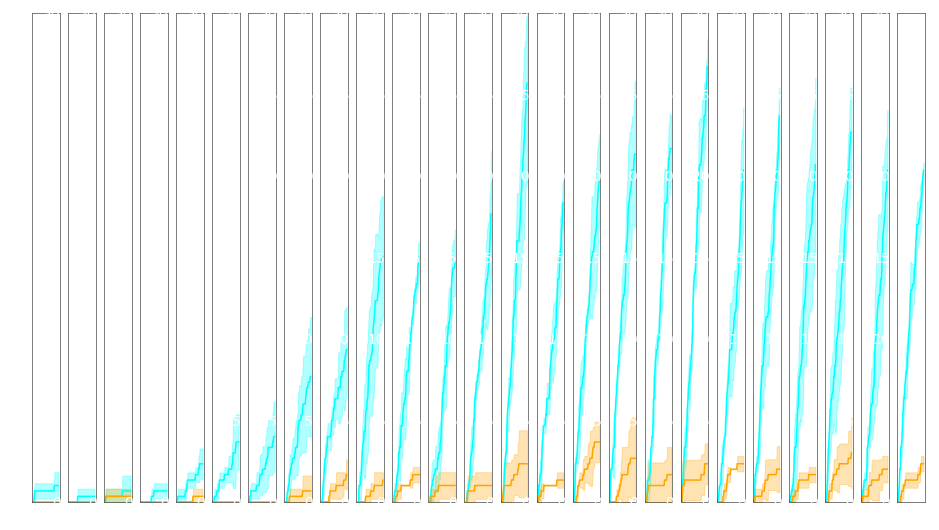

In [174]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=kOFF_samples, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 30
axs =  [None] * kOFF_samples
for n in tqdm(range(kOFF_samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3+1]['y'], color='cyan')
    #axs[n].plot(raw_data_grid_kOFF[n]['data'][m['CB_bind']]['x'], raw_data_grid_kOFF[n]['data'][m['CB_bind']]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3]['y'], averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3+2]['y'], color='cyan', alpha=0.3)
    axs[n].plot(averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3]['y'], averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    #axs[n].set_xticks([0, 60, 120, 180])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 55.13it/s]

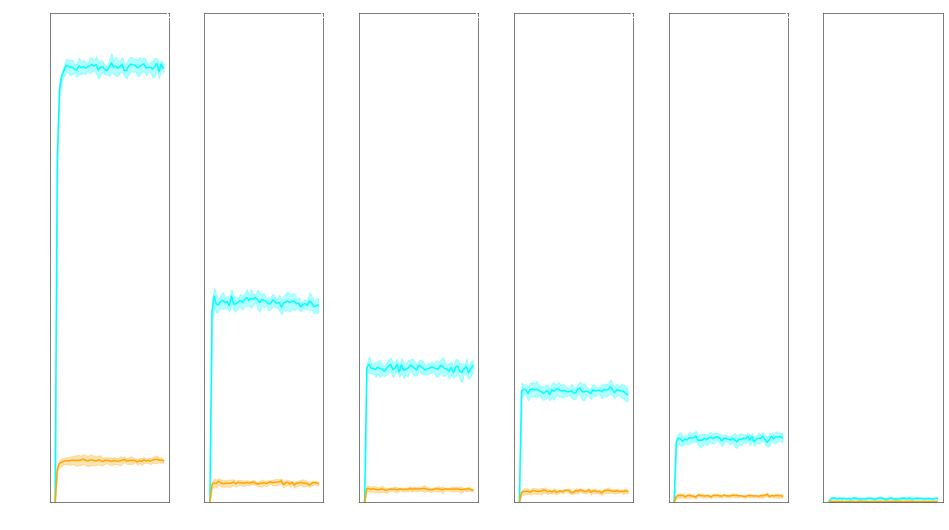

In [170]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=kOFF_samples, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = sim_time #5 * 60
y_axis_lim = 1000
axs =  [None] * kOFF_samples
for n in tqdm(range(kOFF_samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])
    axs[n].plot(averaged_data_grid_kOFF[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CBS']*3+1]['y'], color='cyan')
    axs[n].fill_between(averaged_data_grid_kOFF[n]['data'][m['CBS']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CBS']*3]['y'], averaged_data_grid_kOFF[n]['data'][m['CBS']*3+2]['y'], color='cyan', alpha=0.3)
    axs[n].plot(averaged_data_grid_kOFF[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CBC1S']*3+1]['y'] + averaged_data_grid_kOFF[n]['data'][m['CBC1S0']*3+1]['y'], color='orange')
    axs[n].fill_between(averaged_data_grid_kOFF[n]['data'][m['CBC1S']*3+1]['x'], averaged_data_grid_kOFF[n]['data'][m['CBC1S']*3]['y'] + averaged_data_grid_kOFF[n]['data'][m['CBC1S0']*3]['y'], averaged_data_grid_kOFF[n]['data'][m['CBC1S']*3+2]['y'] + averaged_data_grid_kOFF[n]['data'][m['CBC1S0']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    axs[n].set_ylim([0, y_axis_lim])
    #axs[n].set_xticks([0, 60, 120, 180])
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in exp



[9.59023124e-03 3.00281756e+03 4.12630432e+02]


C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in exp



[2.44459012e-02 3.33498054e+03 9.85285601e+01]


C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in exp

C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in multiply



[2.90378849e-02 3.36144696e+03 7.17163993e+01]


C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in exp

C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in multiply



[3.03371630e-02 3.41109943e+03 2.37257537e+01]



 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00, 28.97it/s]C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in exp

C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in multiply



[3.34735772e-02 3.43239548e+03 2.81582380e+00]


C:\Users\alexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in exp



[3.78413235e-02 3.41223484e+03 2.16256555e+01]



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.69it/s]

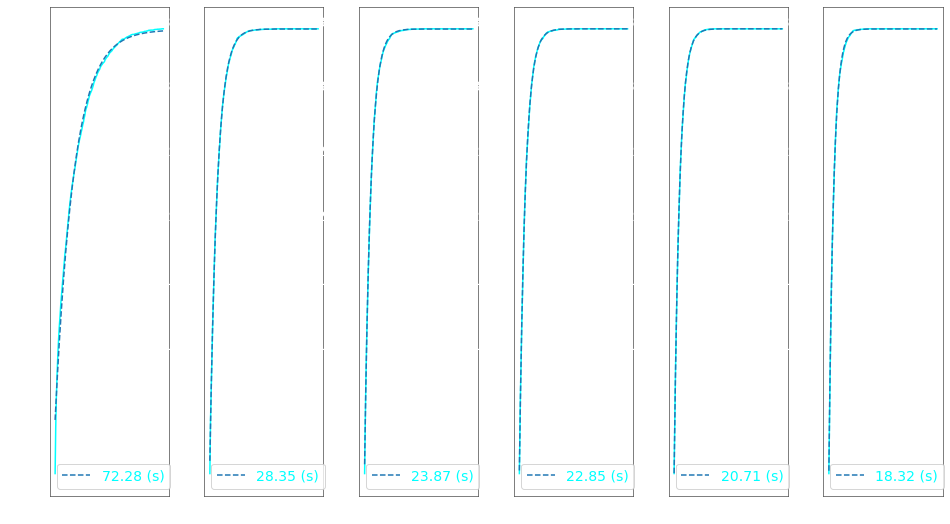

In [171]:
fig_grid = plt.figure()#constrained_layout='Tight')
spec_grid = fig_grid.add_gridspec(ncols=kOFF_samples, nrows=1)#, width_ratios=[1, 1, 1])

#plt.xlabel('Time (s)')
#plt.ylabel(r'Site visitations')

n_labels = ['T24', 'T28', 'T32', 'T36', 'T40', 'T44', 'T48']
x_axis_lim = 5 #5 * 60
y_axis_lim = 32
axs =  [None] * kOFF_samples
for n in tqdm(range(kOFF_samples)):
    axs[n] = fig_grid.add_subplot(spec_grid[0, n])

    axs[n].plot(raw_data_grid_kOFF[n]['data'][m['CB_arrival']]['x'][::100], raw_data_grid_kOFF[n]['data'][m['CB_arrival']]['y'][::100], color='cyan')
    fit, fit_params = fit_rate(raw_data_grid_kOFF[n]['data'][m['CB_arrival']]['x'][::100], raw_data_grid_kOFF[n]['data'][m['CB_arrival']]['y'][::100])
    print(fit_params)
    plt.plot(raw_data_grid_kOFF[n]['data'][m['CB_arrival']]['x'][::100].flatten(), fit, '--', label='{:0.2f} (s)'.format(np.log(2)/(fit_params[0])))
    #axs[n].fill_between(averaged_data_grid_per2[n]['data'][m['S']*3+1]['x'], averaged_data_grid_per2[n]['data'][m['S']*3]['y'], averaged_data_grid_per2[n]['data'][m['S']*3+2]['y'], color='cyan', alpha=0.3)
    #axs[n].plot(averaged_data_grid_per2[n]['data'][m['bind_CBC1']*3+1]['x'], averaged_data_grid_per2[n]['data'][m['bind_CBC1']*3+1]['y'], color='orange')
    #axs[n].fill_between(averaged_data_grid_per2[n]['data'][m['bind_CBC1']*3+1]['x'], averaged_data_grid_per2[n]['data'][m['bind_CBC1']*3]['y'], averaged_data_grid_per2[n]['data'][m['bind_CBC1']*3+2]['y'], color='orange', alpha=0.3)
    #axs[n].plot(averaged_data_grid_per2[n]['data'][m['bind_CBC1P2']*3+1]['x'], averaged_data_grid_per2[n]['data'][m['bind_CBC1P2']*3+1]['y'], color='purple')
    #axs[n].fill_between(averaged_data_grid_per2[n]['data'][m['bind_CBC1P2']*3+1]['x'], averaged_data_grid_per2[n]['data'][m['bind_CBC1P2']*3]['y'], averaged_data_grid_per2[n]['data'][m['bind_CBC1P2']*3+2]['y'], color='purple', alpha=0.3)
    #axs[n].set_xlim([0, x_axis_lim])
    #axs[n].set_ylim([0, y_axis_lim])
    #axs[n].set_xticks([0, 60, 120, 180])
    axs[n].legend()
    '''if n == 2:
        axs[n][k].set_xlabel(kOFF_labels[k])
    if k == 0:
        axs[n][k].set_ylabel(n_labels[n])'''

plt.subplots_adjust(wspace=.3, hspace=.5)

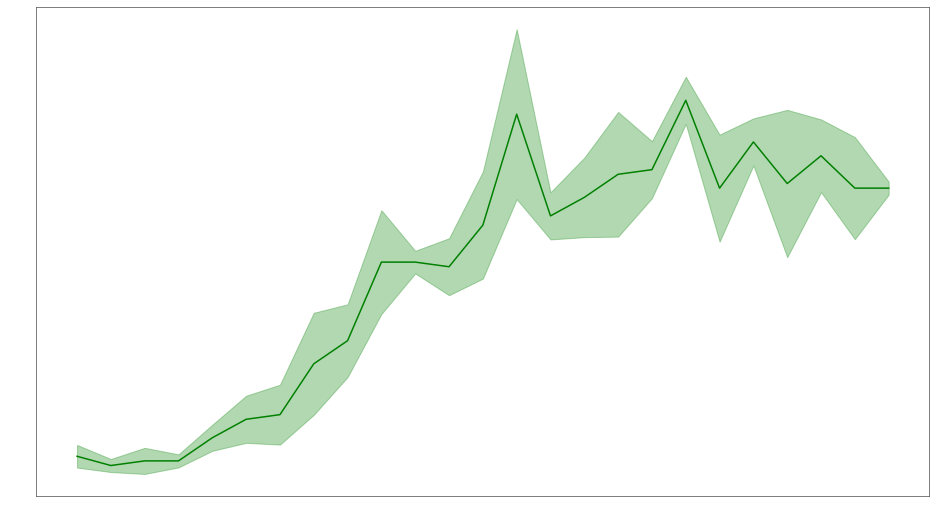

In [176]:
per2_visits_per_min_CB = np.zeros(kOFF_samples)
per2_visits_per_min_CB_std = np.zeros(kOFF_samples)
per2_visits_per_min_CBC1 = np.zeros(kOFF_samples)
per2_visits_per_min_CBC1_std = np.zeros(kOFF_samples)

for n in range(kOFF_samples):
    per2_visits_per_min_CB[n] = 60 * averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3+1]['y'][-1] / 600
    per2_visits_per_min_CB_std[n] = 60 * (averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3+1]['y'][-1] - averaged_data_grid_kOFF[n]['data'][m['CB_bind']*3]['y'][-1]) / 600
    per2_visits_per_min_CBC1[n] = 60 * averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3+1]['y'][-1] / 600
    per2_visits_per_min_CBC1_std[n] = 60 * (averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3+1]['y'][-1] - averaged_data_grid_kOFF[n]['data'][m['CBC1_bind']*3]['y'][-1]) / 600
  
#plt.errorbar(PER2s, visits_per_min, yerr=visits_per_min_std/trajectories)
plt.plot(kOFFs, per2_visits_per_min_CB, color='green')
plt.xscale('log')
plt.fill_between(kOFFs, per2_visits_per_min_CB - per2_visits_per_min_CB_std, per2_visits_per_min_CB + per2_visits_per_min_CB_std, color='green', alpha=0.3)

In [471]:
save_out_array = np.array([per2_visits_per_min_CB, per2_visits_per_min_CB_std, per2_visits_per_min_CBC1, per2_visits_per_min_CBC1_std, per2_visits_per_min_CBC1P2, per2_visits_per_min_CBC1P2_std]).transpose()
columns = ['CB', 'CB_std', 'CBC1', 'CBC1_std', 'CBC1P2', 'CBC1P2_std']

df_save = pd.DataFrame(save_out_array, columns=columns, index=PER2s)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1b Stochastic outputs/6-7-21 Visits per min over Per2 conc.xlsx")